# Microbiome Analysis Pipeline using QIIME2 and Python
This document is to detail the analysis of the fecal microbiome samples collected for the participants of the Chemobrain microbiome project.

This has also been modified for flexibility to increase the ease of use for future study analysis. Study-specific code starts after the rarefactions plots and involves looking at relative abundances of specific taxa, testing for correlations with chemo symptoms, and transforming relative abundances for insertion into Emily's HLR.

Updates to the Stamper pipeline include variable assignment, DADA2 inclusion, sequence renaming, demultiplexing barcode parameters.

## Sample processing details
#### DNA Extraction 
DNeasy PowerSoil HTP 96 kit (Cat No. 12955-4, Qiagen)
#### PCR 
GoTaq Master Mix (Cat No. M5133, Promega, Madison, WI, USA); 515 F (5′-GTGCCAGCMGCCGCGGTAA-3′); 806 R(5′-GGACTACHVGGGTWTCTAAT-3′))
#### Normalization 
SequalPrep Normalization kit (Cat No. A1051001, Thermo Scientific)
#### Sequencing 
Performed by the BioFrontiers Sequencing Core at the University of Colorado Boulder 

## Setup 

### Directory and environment

If you want to allow for the input function, uncomment it and delete the following line.

In [1]:
#directory = input("What directory will work be performed in? Please provide absolute filepath.")
directory = "/Users/johnsterrett/Research-Projects/Boulder/Chemobrain/200608_Elsayed_Lowry-1101"

In [2]:
%cd {directory}

/Users/johnsterrett/Research-Projects/Boulder/Chemobrain/200608_Elsayed_Lowry-1101


In [3]:
pwd #should return the directory with you'll be working in

'/Users/johnsterrett/Research-Projects/Boulder/Chemobrain/200608_Elsayed_Lowry-1101'

Make sure to activate the latest QIIME environment

In [4]:
! source activate /opt/anaconda3/envs/qiime2-2020.6

NOTE: The QIIME2 environment may need to be activated from the command line prior to opening this jupyter notebook. Activating the QIIME2 environment from the Jupyter notebook does not seem to allow for the use the QIIME2 API.

### Data preprocessing 
All relevant metadata were acquired and compiled into a master metadata file. This metadata file was validated using the google addon Keemei.  
The raw sequencing files were copied into a new directory titled "raw_sequences". The file names were also changed to the following as directed by the developers of QIIME2. 
* from "Undetermined_S0_L001_I1_001.fastq.gz" to "barcodes.fastq.gz"
* from "Undetermined_S0_L001_R1_001.fastq.gz" to "forward.fastq.gz"
* from "Undetermined_S0_L001_R2_001.fastq.gz" to "reverse.fastq.gz"

In [ ]:
! cd raw_sequences
! mv Undetermined_S0_L001_I1_001.fastq.gz barcodes.fastq.gz
! mv Undetermined_S0_L001_R1_001.fastq.gz forward.fastq.gz
! mv Undetermined_S0_L001_R2_001.fastq.gz reverse.fastq.gz
! cd ..

### Metadata variable

In [8]:
#metadata = input("What is the name or filepath to your metadata file?")
metadata = "Categorical-meta-v3.tsv"

## Analysis details
 

In [4]:
import sys
print(sys.version)

3.6.10 | packaged by conda-forge | (default, Apr 24 2020, 16:27:41) 
[GCC Clang 9.0.1 ]


Analysis was performed with QIIME2-2020.6, Python 3.6.9, and R 3.5.1

In [158]:
from qiime2 import Visualization, Artifact, Metadata
from qiime2.plugins import feature_table, diversity
from qiime2.plugins.diversity.visualizers import beta_group_significance
from qiime2.plugins.diversity.actions import beta_correlation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from bs4 import BeautifulSoup
from scipy import stats
%matplotlib inline

## Analysis

### Import the data 

In [ ]:
! qiime tools import \
--type EMPPairedEndSequences \
--input-path raw_sequences \
--output-path paired-end-sequences.qza

### Demultiplex 

The "rev-comp-barcodes" and "rev-comp-mapping-barcodes" parameters are required because Golay barcode error detection requires barcodes to run 5'->3'.

In [ ]:
! qiime demux emp-paired \
--m-barcodes-file {metadata} \
--m-barcodes-column BarcodeSequence \
--i-seqs paired-end-sequences.qza \
--p-rev-comp-barcodes \
--p-rev-comp-mapping-barcodes \
--output-dir demux 

/bin/sh: qiime: command not found


In [ ]:
! qiime demux summarize \
--i-data per_sample_sequences.qza \
--o-visualization demux/demux.qzv

### Examine the visualization for joined length insight
This dynamic visualization allows you to determine what percentage of the sequences are at least a certain length. These plots are used to determine to longest length at which 99% of joined sequences are. For this dataset it was determined that length was 251 BPs. 

In [253]:
from qiime2 import Visualization
viz = Visualization.load("demux/demux.qzv")
viz

<visualization: Visualization uuid: f1dd212c-89ce-43f8-8c6f-c06dac852323>

In [ ]:
#Do I want to include this?
#trunc_f = input("Where do you want to truncate the forward reads? Please enter an integer.\n")
#trunc_r = input("Where do you want to truncate the reverse reads? Please enter an integer.\n")
#trim_f = input("Where do you want to trim the forward reads? Please enter an integer.\n")
#trim_r = input("Where do you want to trim the reverse reads? Please enter an integer.\n")

### Generate sequence quality control files 

In [ ]:
#Did not do this, DADA2 filters based on quality, and read quality seems to be very high anyway
#! qiime quality-filter q-score \
#--i-demux demux/per_sample_sequences.qza \
#--o-filtered-sequences demux/demux-filtered.qza \
#--o-filter-stats demux/demux-filter-stats.qza

### Denoise using DADA2

In [ ]:
! qiime dada2 denoise-paired \
--i-demultiplexed-seqs demux/demux-filtered.qza \
--p-trunc-len-f 295 \
--p-trunc-len-r 237 \
--p-trim-left-f 0 \
--p-trim-left-r 0 \
--output-dir dada2-results/

In [ ]:
! qiime feature-table summarize \
--i-table dada2-results/table.qza \
--o-visualization dada2-results/table.qzv \
--m-sample-metadata-file {metadata}

In [9]:
viz = Visualization.load("dada2-results/table.qzv")
viz

<visualization: Visualization uuid: f162e01b-279b-4d7c-8a52-89bbce6ebaeb>

### OR Denoise with Deblur

No need to do this if you just want to use DADA2. DADA2 takes a longer but seems to recover a few more OTUs. They're predominantly equivalent, but DADA2 supports paired-end reads.

#### Join reads first

In [ ]:
! qiime vsearch join-pairs \
--i-demultiplexed-seqs demux/per_sample_sequences.qza \
--o-joined-sequences demux/demux-joined.qza

In [ ]:
! qiime demux summarize \
--i-data demux/demux-joined.qza \
--o-visualization demux/demux-joined.qzv

#### Make sure we didn't lose quality

In [6]:
viz = Visualization.load("demux/demux-joined.qzv")
viz

<visualization: Visualization uuid: cad9c2a9-57e4-4094-9de6-c5f5a2aa1218>

#### Filter joined reads for quality

In [ ]:
! qiime quality-filter q-score-joined \
--i-demux demux/demux-joined.qza \
--o-filtered-sequences demux/demux-joined-filtered.qza \
--o-filter-stats demux/demux-joined-filter-stats.qza

#### Actually deblur

In [ ]:
! qiime deblur denoise-16S \
--i-demultiplexed-seqs demux/demux-joined-filtered.qza \
--p-trim-length 251 \
--p-sample-stats \
--output-dir deblur-results

In [ ]:
! qiime feature-table summarize \
--i-table deblur-results/table.qza \
--o-visualization deblur-results/table.qzv \
--m-sample-metadata-file {metadata}

In [7]:
viz = Visualization.load("deblur-results/table.qzv")
viz

ValueError: deblur-results/table.qzv does not exist.

### DADA2 or Deblur?

In [20]:
rep_seqs = ''
table = ''


DA_or_De = input("Are you using DADA2 results? \nAnswer Y for DADA2 and N for Deblur.\n")

if DA_or_De == "Y":
    rep_seqs = "dada2-results/representative_sequences.qza"
    table = "dada2-results/table.qza"
elif DA_or_De == "N":
    rep_seqs = "deblur-results/representative_sequences.qza"
    table = "deblur-results/table.qza"
else:
    raise ValueError("Error: Please answer either \"Y\" or \"N\".")

Are you using DADA2 results? 
Answer Y for DADA2 and N for Deblur.
Y


In [21]:
rep_seqs #test

'dada2-results/representative_sequences.qza'

### Examine the visualization for rarefaction level insight 
From Chris Stamper: **Actually probably should have Maggie input her r code for rarefaction insight**

### SEPP analysis 
From Chris: This is an analysis that was recommended by the Lozupone lab to tighten up the tree by removing outlier taxa. You can perform this analysis with the reference database being based on greengenes or silva. Silva is preferred as it is more up-to-date and you need to download that reference database separatly. Use the link or the following address to download the database used in this analysis.  
[silva sepp database](https://data.qiime2.org/2019.10/common/sepp-refs-silva-128.qza)  
https://data.qiime2.org/2019.10/common/sepp-refs-silva-128.qza

In [19]:
! qiime fragment-insertion sepp \
--i-representative-sequences {rep_seqs} \
--i-reference-database sepp-refs-silva-128.qza \
--o-tree insertion-tree.qza \
--o-placements insertion-placements.qza

Usage: qiime fragment-insertion sepp [OPTIONS]

  Perform fragment insertion of sequences using the SEPP algorithm.

Inputs:
  --i-representative-sequences ARTIFACT FeatureData[Sequence]
                       The sequences to insert into the reference tree.
                                                                    [required]
  --i-reference-database ARTIFACT SeppReferenceDatabase
                       The reference database to insert the representative
                       sequences into.                              [required]
Parameters:
  --p-alignment-subset-size INTEGER
                       Each placement subset is further broken into subsets
                       of at most these many sequences and a separate HMM is
                       trained on each subset.                 [default: 1000]
  --p-placement-subset-size INTEGER
                       The tree is divided into subsets such that each subset
                       includes at most these many subsets

In [14]:
! qiime fragment-insertion filter-features \
--i-table {table} \
--i-tree insertion-tree.qza \
--o-filtered-table filtered-table.qza \
--o-removed-table removed-table.qza

Saved FeatureTable[Frequency] to: filtered-table.qza
Saved FeatureTable[Frequency] to: removed-table.qza


In [255]:
! qiime feature-table summarize \
--i-table removed-table.qza \
--o-visualization removed-table.qzv

Saved Visualization to: removed-table.qzv


In [256]:
viz = Visualization.load('removed-table.qzv')
viz

<visualization: Visualization uuid: 7e5aed1c-f76c-4f91-bacb-2de59e3c6b62>

I downleaded this [silva reference taxonomy file](https://data.qiime2.org/2020.6/common/silva-138-99-tax.qza) and will therefore need to cite 
`Bokulich, N.A., Robeson, M., Dillon, M.R. bokulich-lab/RESCRIPt. Zenodo. http://doi.org/10.5281/zenodo.3891931` because it was reformatted by developers using Nicholas Bokulich's RESCRIPt package.

I tried with the silva 515f/806r specific taxa database, and was met with an error that ~170,000 OTUs did not have mappings in the reference taxonomy. Tried again with the full silva, and ~112,000 did not have mappings.

In [23]:
! qiime fragment-insertion classify-otus-experimental \
--i-representative-sequences {rep_seqs} \
--i-tree insertion-tree.qza \
--i-reference-taxonomy silva-138-99-tax-515-806.qza \
--o-classification sepp-silva-taxonomy.qza

Plugin error from fragment-insertion:

  Not all OTUs in the provided insertion tree have mappings in the provided reference taxonomy. Taxonomy missing for the following 173857 feature(s):
  JQ466395.1.1429
  KM356640.1.1457
  KC534255.1.1369
  LBLM01033674.20306.22039
  GU061050.1.1386
  EF019850.1.1402
  EU802115.1.1482
  FM213040.1.1513
  KF069924.1.1337
  EU808969.1.1292
  EF099512.1.1399
  AJ291844.1.1291
  HQ782970.1.1443
  KP403286.1.1426
  AY864634.1.1420
  KF876904.1.1427
  KC554128.1.1495
  AY012359.1.1721
  DQ113699.1.1304
  AOCO010143983.2.1477
  KJ479311.1.1520
  AJ422062.1.1951
  JQ361727.1.1391
  EU773690.1.1400
  AB930556.1.1446
  KM356487.1.1500
  KC845949.1.1497
  JN438079.1.1426
  JQ463529.1.1397
  KJ410571.1.1340
  AVPS01000017.3788.5336
  EU468237.1.1320
  KC672480.1.1758
  EU675635.1.1752
  HQ770068.1.1442
  AWOJ01324218.986.2275
  AY521864.1.2016
  JX224101.1.1277
  FJ984716.1.1548
  GU362972.1.1466
  HQ176160.1.1475
  HQ795145.1.1450
  KR906401.1.1430
  AB542415

  JX223648.1.1524
  JQ466676.1.1379
  KT280488.1.1455
  EF572044.1.1450
  KT989346.1.1702
  FJ746105.1.1371
  DQ455733.1.1238
  EU456087.1.1310
  KF068392.1.1345
  GQ491140.1.1364
  JX095410.1.1329
  DQ796368.1.1387
  HQ395128.1.1505
  EF156616.1.1334
  KM221247.1.934
  EU854914.1.1328
  JN496550.1.1372
  KC260454.1.1351
  HQ774948.1.1430
  HQ781988.1.1442
  EU774928.1.1397
  LN562179.1.1380
  AY572030.1.1340
  DQ490345.1.1446
  HM438317.1.1441
  FJ040449.1.1697
  KT427397.1.1448
  LC026813.1.1413
  KC290838.1.1508
  KJ763128.1.1798
  FAOM01331953.4602.5938
  FM211672.1.1502
  KT165090.1.919
  KF065574.1.1234
  FJ478698.1.1523
  GQ461663.1.1400
  HQ758609.1.1475
  AY630552.1.1739
  AJ011508.1.1486
  M22509.1.1466
  FJ712385.1.1455
  AF515299.1.1773
  EF654700.1.1496
  KP091104.1.1543
  JQ607249.1.1420
  AF350233.1.1773
  JN934989.1.1796
  FN821836.1.1503
  EU735028.1.1490
  HM267263.1.1366
  AY214190.1.1483
  AF019929.1.1317
  AB983608.1.1744
  JX223318.1.1511
  FQ032810.6584.8099
  AB

  FJ193774.1.1410
  AB771796.1.1673
  HQ245961.4.1423
  KM194406.1.1063
  HQ796573.1.1445
  KF984422.1.1518
  EF019227.1.1403
  AF033038.1.1785
  AB636815.1.1071
  DQ325574.1.1341
  JQ073728.1.1515
  KF063966.1.1342
  KC551758.1.1506
  KC122689.1.1483
  CU921887.1.1322
  JX441487.1.1435
  FJ976333.1.1353
  HQ775914.1.1438
  AB694174.1.1525
  DQ833782.1.1380
  KJ534297.1.1606
  KJ569673.1.1522
  EU510896.1.1394
  EU410618.1.1402
  EU244049.1.1493
  JQ205083.1.1349
  DQ808695.1.1387
  HM628622.1.1578
  JQ452446.1.1391
  GU821433.1.1304
  DQ016563.1.1742
  KF110537.1.1365
  KT880385.1.1480
  HQ782338.1.1454
  JF139719.1.1367
  HQ883949.1.1540
  AB845211.1.1243
  FQ658795.1.1350
  EU134022.1.1325
  KF063061.1.1350
  FJ191403.1.1466
  EF081302.1.1741
  GQ132515.1.1354
  FJ673616.1.1397
  EU454614.1.1387
  KU060865.1.1440
  JQ448478.1.1416
  FJ365710.1.1352
  FQ658742.1.1352
  JN623433.1.1399
  DQ985057.1.1480
  FJ369231.1.1312
  KT225499.1.1476
  HM008837.1.1351
  HM186169.1.1367
  KF111226

  GU940793.1.1390
  EU470891.1.1382
  FJ802307.1.1208
  EU463605.1.1321
  HG780360.1.1270
  AB934719.1.1369
  KC554940.1.1541
  AB486096.1.1309
  KM878218.1.1457
  JNFL01000172.3550.5091
  AB427150.1.1305
  LN564351.1.1362
  JF139341.1.1300
  KJ528310.1.1390
  KP278059.1.1425
  Y11750.1.1831
  LN565407.1.1375
  GQ417405.1.1465
  JX889320.1.1496
  EU828383.1.1429
  JN490038.1.1294
  FJ678760.1.1418
  HE602901.1.1421
  JX310173.1.1447
  HM756471.1.1305
  AB806986.1.1489
  HQ163149.1.1351
  GQ181483.1.1362
  HQ843742.1.1500
  GU472715.1.1448
  KJ600976.1.1461
  FJ192107.1.1406
  HQ764023.1.1468
  GQ130120.1.1464
  JN896876.1.1338
  HK557220.1.1327
  X92145.1.1496
  DQ823943.1.1391
  AB167236.1.1398
  JN515677.1.1378
  GQ014711.1.1348
  EU774642.1.1383
  LFJF01048254.17370.18598
  DQ799844.1.1392
  LKUO01005804.3774.5132
  JF192474.1.1371
  GQ406144.1.1510
  EU741110.1.1342
  FJ363357.1.1373
  JQ465424.1.1407
  JF706534.1.1396
  AJ841508.1.1845
  JQ688007.1.1822
  JX222254.1.1497
  AY24740

  EU463595.1.1374
  KC486592.1.1619
  JQ210239.1.1374
  JQ515474.1.1441
  EF424398.1.1311
  FR684161.1.1478
  JN867272.1.1439
  EF209792.1.1837
  JN023658.1.1506
  KU243292.1.1286
  JN128275.1.1385
  DQ809662.1.1394
  KM489154.1.1398
  HM252880.1.1368
  JQ084830.1.1448
  EU834771.1.1470
  HM008850.1.1370
  EF098090.1.1356
  GQ155332.1.1344
  HM269008.1.1373
  DQ069198.1.1515
  HM061805.1.1472
  JQ473712.1.1392
  AY284632.1.1719
  JF357643.1.1701
  DQ630681.1.1490
  FJ365213.1.1354
  HQ288944.1.1533
  EU214933.1.1470
  EU459270.1.1362
  APMJ01003930.66987.68238
  KR814269.1.1520
  FJ363392.1.1338
  JN707698.1.1765
  JX525163.1.1420
  EU132033.1.1376
  JQ226204.1.1632
  JQ437583.1.1419
  GDZX01002918.1.1379
  JQ460669.1.1409
  GQ849291.1.1259
  KU561621.1.1474
  GQ866094.1.1469
  JN713559.1.1526
  EU472290.1.1313
  JN391571.1.1510
  LFME01000064.3689.5235
  KM083502.1.1464
  AY012361.1.1752
  JX860247.1.1224
  GU553458.1.1412
  KT722383.1.1934
  KC354629.1.1433
  HK555921.1.1319
  JQ4670

  AB076621.1.1816
  JN013147.1.1457
  FJ230922.1.1403
  EU452277.1.1391
  AB277851.1.1504
  JQ801048.1.1493
  AF085475.1.1707
  EU774629.1.1385
  CZHE02025204.861.2646
  FJ367167.1.1361
  GU325580.1.1658
  JN457268.1.1392
  HQ259942.1.1447
  EU771906.1.1313
  AM935092.1.1317
  FR683217.1.1443
  JQ511855.1.1379
  JN470578.1.1368
  JN180141.1.1458
  EU862566.1.1565
  AY425288.1.1424
  AY919777.1.1720
  EU777835.1.1283
  GU819725.1.1201
  CU924329.1.1338
  KC925833.1.913
  LN568925.1.1366
  DQ456033.1.1434
  GU821830.1.1217
  KF963792.1.1309
  GU108566.1.1397
  KC119158.1.1280
  CU920794.1.1362
  DQ800848.1.1389
  JQ213136.1.1355
  LT571436.1580065.1581593
  EU287242.1.1500
  EU776017.1.1389
  FJ366480.1.1344
  JN038743.1.1489
  JF236191.1.1338
  GQ448212.1.1369
  HM845753.1.1366
  JX854347.1.1290
  JX023047.1.978
  EU472961.1.1401
  KT900587.1.1420
  EU340169.1.1364
  AF371877.1.1450
  EF100258.1.1365
  EF099443.1.1393
  GU559768.1.1433
  LN567363.1.1330
  KT154834.1.1440
  KJ934163.1.22

  JQ221954.1.915
  X54744.1.1481
  JQ189985.1.1375
  KJ761276.1.1778
  EU244057.1.1474
  AB555319.1.1470
  JX048101.1.1406
  JQ455591.1.1393
  JN434868.1.1445
  EU557254.1.1945
  EU504079.1.1400
  JX567422.1.1336
  GQ047989.1.1350
  KC003655.1.906
  FJ562139.1.1233
  DQ924842.1.1327
  JN105296.1.1449
  JN866647.1.1395
  GQ040684.1.1339
  HQ806887.1.1427
  KU230522.1.1503
  JX527284.1.1434
  DQ159185.1.1457
  KT248518.1.1260
  KM194166.1.993
  KT834797.1.1491
  GECJ01043397.3241.5063
  AY991672.1.1283
  EF660297.1.1686
  EU459221.1.1401
  AAWU01040617.18802.20742
  JQ712026.1.1487
  JX881732.1.1472
  KP189376.1.1550
  HK693761.1.1326
  JQ450603.1.1365
  LC008534.1.2726
  LTAE01000247.57378.59306
  AB185772.1.1525
  EF436445.1.1491
  KF859718.1.1499
  JQ452933.1.1383
  JQ448770.1.1402
  EU488410.1.1386
  APFE020554842.5170.6971
  GU113031.1.1521
  EU134358.1.1408
  KJ013370.1.1512
  GQ134340.1.1385
  HM278974.1.1360
  JX155394.1.1397
  KP064196.1.1560
  JQ452018.1.1402
  JX997874.1.1457


  DQ642857.1.1856
  GQ347286.1.1436
  KF939127.1.1461
  AY338233.1.1496
  FJ612389.1.1501
  KJ763040.1.1763
  KT873250.1.1512
  GQ327479.1.1321
  AX002996.1.1379
  JX882969.1.1471
  FJ946535.1.1290
  DQ804575.1.1404
  KM194369.1.976
  AY630492.1.1733
  AY923102.1.1255
  HQ763067.1.1448
  KF770933.1.1476
  EU741215.1.1492
  KF786757.1.1357
  AF182818.1.1692
  DQ456414.1.1450
  DQ809467.1.1294
  JQ684455.1.1537
  HQ802105.1.1438
  HQ671953.1.1483
  AF530145.1.1431
  KT308578.1.1424
  JN497249.1.1441
  EU774503.1.1402
  KF545060.1.1426
  KJ569207.1.1381
  AB286466.1.1441
  AF519241.1.1771
  EU772042.1.1364
  AM889153.1.1518
  JQ183346.1.1350
  EU185439.1.1376
  LN569723.1.1366
  KF071177.1.1375
  DQ660822.1.1442
  AB288927.1.1308
  KF464824.1.1215
  DQ808167.1.1377
  DQ808120.1.1391
  HQ818001.1.1436
  AB533968.1.1521
  JOIU01000063.3459.4966
  LN569037.1.1356
  HQ761675.1.1444
  GU593652.1.1340
  HF571535.1.1368
  EU464168.1.1383
  HQ815585.1.1437
  KT351720.1.1512
  GQ261750.1.1469
  KT

  KX077450.1.912
  EF573671.1.1498
  HQ010706.1.1485
  EU240396.1.1399
  AB308361.1.1491
  JN452128.1.1406
  AM936076.1.1342
  KF703549.1.1441
  EU467172.1.1383
  EF527114.1.1367
  GQ980242.1.1435
  JN443236.1.1244
  JQ458480.1.1405
  JN023103.1.1454
  KP868648.1.1405
  EU801776.1.1366
  HM828347.1.1364
  JN491518.1.1436
  KJ127940.1.1446
  GQ327194.1.1323
  AB550131.1.1548
  GQ098962.1.1357
  JX882182.1.1482
  AGKD04000713.184416.186215
  JQ210442.1.1348
  GQ340465.1.1452
  ACVE01000002.312421.313923
  CU924119.1.1323
  JQ464539.1.1417
  KC511079.1.1727
  EU090727.1.1403
  JRWT01012925.1370.3140
  JX132233.1.1630
  JF186157.1.1367
  EF688242.1.1490
  EU133330.1.1277
  GQ023334.1.1347
  KP183060.1.1518
  KJ756333.1.1391
  EU287214.1.1500
  AKXU01001378.128270.130054
  KC001791.1.1291
  AB270089.1.1512
  JN811699.1.1359
  KC218416.1.1754
  JX105529.1.1506
  JQ474176.1.1378
  EU732604.1.1314
  EF020264.1.1415
  LN623583.1.1575
  JN391816.1.1493
  KR150416.1.1428
  AB555438.1.1502
  JQ769

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Assigning taxonomy

Giving up on fragment-insertion classify-otus, I'm just using feature classifier with a [pretrained classifier](https://data.qiime2.org/2020.6/common/silva-138-99-515-806-nb-classifier.qza)

In [27]:
! qiime feature-classifier classify-sklearn \
--i-reads {rep_seqs} \
--i-classifier silva-138-99-515-806-nb-classifier.qza \
--output-dir silva-classified

Saved FeatureData[Taxonomy] to: silva-classified/classification.qza


In [30]:
! qiime metadata tabulate \
--m-input-file silva-classified/classification.qza \
--o-visualization silva-classified/classification.qzv

Saved Visualization to: silva-classified/classification.qzv


In [ ]:
! mv silva-classified/classification.qza taxonomy-silva.qza
! mv silva-classified/classification.qzv taxonomy-silva.qzv

In [11]:
viz = Visualization.load('taxonomy-silva.qzv')
viz

<visualization: Visualization uuid: 49fcd876-d445-49ba-b56b-833ad7dbe958>

In [32]:
! mv silva-classified/classification.qza taxonomy-silva.qza
! mv silva-classified/classification.qzv taxonomy-silva.qzv

### Filter out Mitochondria and Chloroplast

I don't see why this is a necessary step, but it was included in Chris Stamper's pipeline. Deblur and DADA2 both include de novo Chimera removal. Perhaps it is just another checkpoint. I'll look into it.

In [33]:
! qiime taxa filter-table \
  --i-table filtered-table.qza \
  --i-taxonomy taxonomy-silva.qza \
  --p-exclude mitochondria,chloroplast \
  --o-filtered-table noMito_noChloro-filtered-table.qza 

Saved FeatureTable[Frequency] to: noMito_noChloro-filtered-table.qza


Now let's compare the two and see how many were removed

In [36]:
! qiime feature-table summarize \
--i-table filtered-table.qza \
--o-visualization filtered-table.qzv \
--m-sample-metadata-file {metadata}

viz = Visualization.load('filtered-table.qzv')
viz

Saved Visualization to: filtered-table.qzv


<visualization: Visualization uuid: aa85e96a-ec79-4231-afca-1ccfe0b26099>

In [35]:
! qiime feature-table summarize \
--i-table noMito_noChloro-filtered-table.qza \
--o-visualization noMito_noChloro-filtered-table.qzv \
--m-sample-metadata-file {metadata}

viz = Visualization.load('noMito_noChloro-filtered-table.qzv')
viz

Saved Visualization to: noMito_noChloro-filtered-table.qzv


<visualization: Visualization uuid: e19c142b-48a2-4b33-9926-d5a60bb10022>

In [258]:
viz = Visualization.load('noMito_noChloro-filtered-table.qzv')
viz

<visualization: Visualization uuid: e19c142b-48a2-4b33-9926-d5a60bb10022>

In [59]:
dada2_table = Artifact.load('dada2-results/table.qza')
filtered_table = Artifact.load('filtered-table.qza')
no_M_C_table = Artifact.load('noMito_noChloro-filtered-table.qza')

df_tab = dada2_table.view(pd.DataFrame)
df_filt = filtered_table.view(pd.DataFrame)
df_MC = no_M_C_table.view(pd.DataFrame)

tables = ['df_tab', 'df_filt', 'df_MC']


total_frequencies = {x: globals()[x].values.sum() for x in tables}


print('filtered by sepp: {}'.format(total_frequencies['df_tab']-total_frequencies['df_filt']))
print('filtered by Mito/Chloro: {}'.format(total_frequencies['df_filt']-total_frequencies['df_MC']))

filtered by sepp: 0.0
filtered by Mito/Chloro: 811.0


Looks like it actually was necessary! (Note: look into how qiime taxa filtering differs from DADA2 chimera filtering)

### Filter out bloomed taxa in samples that have been shipped 

This isn't necessary for Chemobrain, no shipped samples

#### Divide the feature table into separate feature tables: one for the shipped samples and one for not shipped samples

In [60]:
#! qiime feature-table filter-samples \
#  --i-table noMitoChloro-filtered-table.qza \
#  --m-metadata-file Vet_metadata_110519.tsv \
#  --p-where "[Shipped]='Yes'" \
#  --o-filtered-table Shipped_noMitoChloro-filtered-table.qza 

In [61]:
#! qiime feature-table filter-samples \
#  --i-table noMitoChloro-filtered-table.qza \
#  --m-metadata-file Vet_metadata_110519.tsv \
#  --p-where "[Shipped]='No'" \
#  --o-filtered-table NotShipped_noMitoChloro-filtered-table.qza 

#### Remove the sequences that the AGP team determined bloom during shipping
The file was generated by cross referencing the sequences that the AGP determined bloomed during shipping to the sequences produced in our feature table to determine the OTU IDs to be removed. 

In [ ]:
#! qiime feature-table filter-features \
#  --i-table Shipped_noMitoChloro-filtered-table.qza \
#  --m-metadata-file Bloom_OTU_ID_Index.txt \
#  --p-exclude-ids \
#  --o-filtered-table noBloom_Shipped_noMitoChloro-filtered-table.qza

#### Merge the de-bloomed shipped samples feature table with the not shipped samples feature table

In [ ]:
#! qiime feature-table merge \
#  --i-tables noBloom_Shipped_noMitoChloro-filtered-table.qza \
#  --i-tables Not_Shipped_noMitoChloro-filtered-table.qza \
#  --o-merged-table Merged_NoBloomShipped_noMitoChloro-filtered-table.qza

### Core diversity analysis
Use the rarefaction level that has been determined by looking at the R visualizations

In [72]:
! qiime diversity core-metrics-phylogenetic \
  --i-phylogeny insertion-tree.qza \
  --i-table noMito_noChloro-filtered-table.qza \
  --p-sampling-depth 13100 \
  --m-metadata-file {metadata} \
  --output-dir core-diversity-results

Saved FeatureTable[Frequency] to: core-diversity-results/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: core-diversity-results/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: core-diversity-results/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: core-diversity-results/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: core-diversity-results/evenness_vector.qza
Saved DistanceMatrix to: core-diversity-results/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: core-diversity-results/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: core-diversity-results/jaccard_distance_matrix.qza
Saved DistanceMatrix to: core-diversity-results/bray_curtis_distance_matrix.qza
Saved PCoAResults to: core-diversity-results/unweighted_unifrac_pcoa_results.qza
Saved PCoAResults to: core-diversity-results/weighted_unifrac_pcoa_results.qza
Saved PCoAResults to: core-diversity-results/jaccard_pcoa_results.qza
Saved PCoAResults to: core-diversity-r

In [4]:
from qiime2 import Metadata
from qiime2.plugins import diversity
from qiime2.plugins import feature_table

In [12]:
metadata_API = Metadata.load('Categorical-meta-v3.tsv')
metadf = metadata_API.to_dataframe()

In [20]:
feattable = Artifact.load('noMito_noChloro-filtered-table.qza')

In [86]:
rarefied = feature_table.methods.rarefy(table=feattable,sampling_depth = 13100).rarefied_table

otus = diversity.methods.alpha(table=rarefied, metric='observed_otus').alpha_diversity
otus_g_sig = diversity.actions.alpha_group_significance(otus, metadata_API)

otus_g_sig.visualization.export_data('otus_g_sig')

In [192]:
alphas = ['observed_otus', 'shannon', 'pielou_e']

In [193]:
pwd

'/Users/johnsterrett/Research-Projects/Boulder/Chemobrain/200608_Elsayed_Lowry-1101'

In [191]:
import os

for alpha in alphas:
    path = os.getcwd() + '/' + alpha
    go_back = os.getcwd()
    
    globals()[alpha] = diversity.methods.alpha(table=rarefied,
                                               metric=alpha).alpha_diversity
    globals()[alpha + '_sig'] = diversity.actions.alpha_group_significance(globals()[alpha], 
                                                                           metadata_API)
    globals()[alpha + '_sig'].visualization.export_data(alpha)
    
    
    df = pd.DataFrame()
    variables = []
    n=0

    os.chdir(path)
    
    for entry in os.listdir(path):
        if entry.endswith(".csv"):
            with open(entry) as f:
                dfn = pd.read_csv(entry)
                df = pd.concat([df,dfn],axis=1)

            variables.append(str(entry)[24:-4])
            n+=1

        else:
            continue

    df.columns = pd.MultiIndex.from_product([variables, df.iloc[:,-5:]])

    print('Added the results from {} significance tests for {}.'.format(n,alpha))

    df.to_csv('../{}.csv'.format(alpha))
    print('Exported csv for {}'.format(alpha))
    
    os.chdir(go_back)


Added the results from 112 significance tests for 
exported csv for observed_otus
Added the results from 112 significance tests for 
exported csv for shannon
Added the results from 112 significance tests for 
exported csv for pielou_e


In [195]:
for alpha in alphas:
    path = os.getcwd() + '/' + alpha
    !rm -r {path}

Now for the phylogenetic diversity

In [13]:
tree = Artifact.load('insertion-tree.qza') 

In [199]:
faith = diversity.methods.alpha_phylogenetic(table=rarefied,phylogeny=tree,metric='faith_pd').alpha_diversity 
#faith is the only option for phylogenetic diversity


faith_sig = diversity.actions.alpha_group_significance(faith, metadata_API)
faith_sig.visualization.export_data('faith')

path = os.getcwd() + '/faith'
go_back = os.getcwd()

df = pd.DataFrame()
variables = []
n=0

os.chdir(path)

for entry in os.listdir(path):
    if entry.endswith(".csv"):
        with open(entry) as f:
            dfn = pd.read_csv(entry)
            df = pd.concat([df,dfn],axis=1)

        variables.append(str(entry)[24:-4])
        n+=1

    else:
        continue

df.columns = pd.MultiIndex.from_product([variables, df.iloc[:,-5:]])

print('Added the results from {} significance tests for {}.'.format(n,'faith'))

df.to_csv('../{}.csv'.format('faith'))
print('Exported csv for {}'.format('faith'))

os.chdir(go_back)

Added the results from 112 significance tests for faith.
Exported csv for faith


In [311]:
path = os.getcwd() + '/faith_corr'
go_back = os.getcwd()

os.chdir(go_back)

df = pd.DataFrame()
n=0
variables = []


os.chdir(path)
for entry in os.listdir(path):
    if entry.endswith('.jsonp'):
        with open(entry) as f:
            data = f.read()    
            data = data.split('(')[1].strip(');')[18:]
            
            try:
                json_data = json.loads('{' + data.split('},{')[2])
            
            except IndexError:
                json_data = json.loads('{' + data.split('null,{')[1])
            
            
        dfn = pd.DataFrame.from_dict(json_data, orient='index',columns=[str(entry)[7:-6]])

        df = pd.concat([df,dfn],axis=1)
        n+=1
        variables.append(str(entry)[7:-6])

    else:
        continue

        
os.chdir(go_back)
    
print('Added correlation results for {} columns.'.format(n))

df.to_csv('faith_corr.csv')

Added correlation results for 143 columns.


In [306]:
df

fact_r_imp_4 fact_r_imp_10    cesd_5 cesd_total fact_c_com_4  \
method         Spearman      Spearman  Spearman   Spearman     Spearman   
testStat         0.1615        0.2604   -0.1740    -0.3277          nan   
pVal             0.3855        0.1571    0.3491     0.0719          nan   
sampleSize           31            31        31         31           31   

           fact_c_r_qol_total promis_20   cesd_12   cesd_10 promis_22  ...  \
method               Spearman  Spearman  Spearman  Spearman  Spearman  ...   
testStat               0.0904   -0.1053   -0.2723   -0.1999   -0.4524  ...   
pVal                   0.6287    0.5729    0.1384    0.2810    0.0106  ...   
sampleSize                 31        31        31        31        31  ...   

           fact_c_imp_4       age fact_r_com_4 fact_c_imp_11 stress_scale_5r  \
method         Spearman  Spearman     Spearman      Spearman        Spearman   
testStat        -0.1615    0.0105          nan       -0.2548         -0.1550   
pVal             0.3855    0.9553          nan        0.1665          0.4051   
sampleSize           31        31           31            31              31   

           promis_11 fact_c_imp_6 fact_c_ab_7 fact_r_imp_8    cesd_9  
method      Spearman     Spearman    Spearman     Spearman  Spearman  
testStat     -0.1971      -0.1583      0.1731       0.1693   -0.0433  
pVal          0.2879       0.3950      0.3516       0.3625    0.8172  
sampleSize        31           31          31           31        31  

[4 rows x 143 columns]

In [207]:
os.getcwd()

'/Users/johnsterrett/Research-Projects/Boulder/Chemobrain/200608_Elsayed_Lowry-1101/beta_corr_results/beta_corr_results/beta_corr_results'

In [246]:
%cd /Users/johnsterrett/Research-Projects/Boulder/Chemobrain/200608_Elsayed_Lowry-1101

/Users/johnsterrett/Research-Projects/Boulder/Chemobrain/200608_Elsayed_Lowry-1101


In [247]:
import json

go_back = os.getcwd()

feattable = Artifact.load('noMito_noChloro-filtered-table.qza')
alphas = ['observed_otus', 'shannon', 'pielou_e', 'faith_pd']
depth = 13100

rarefied = feature_table.methods.rarefy(table=feattable,sampling_depth=depth).rarefied_table


for alpha in alphas:
    #identify the directory each results will go to, establish a 'home'
    path = os.getcwd() + '/' + alpha
    go_back = os.getcwd()

    #faith requires a different method because it's phylogenetic
    if alpha == 'faith_pd':
        globals()[alpha] = diversity.methods.alpha_phylogenetic(table=rarefied,
            phylogeny=tree,metric='faith_pd').alpha_diversity 

    #All others are just plain alpha
    else:
        globals()[alpha] = diversity.methods.alpha(table=rarefied,
            metric=alpha).alpha_diversity
    
    globals()[alpha + '_corr'] = diversity.actions.alpha_correlation(globals()[alpha], 
                                                                     metadata_API.filter_columns(drop_zero_variance=True), 
                                                                     method='pearson',
                                                                     intersect_ids=True)

    globals()[alpha + '_corr'].visualization.export_data('{}_correlation'.format(alpha))
    
    path_corr = os.getcwd() + '/{}_correlation'.format(alpha)

    df = pd.DataFrame()
    n=0
    variables = []


    os.chdir(path_corr)
    for entry in os.listdir(path_corr):
        if entry.endswith('.jsonp'):
            with open(entry) as f:
                data = f.read()    
                data = data.split('(')[1].strip(');')[18:]

                try:
                    json_data = json.loads('{' + data.split('},{')[2])
                
                #sometimes there is a ',null,' before what we want
                except IndexError:
                    json_data = json.loads('{' + data.split('null,{')[1])


            dfn = pd.DataFrame.from_dict(json_data, orient='index',columns=[str(entry)[7:-6]])

            df = pd.concat([df,dfn],axis=1)
            n+=1
            variables.append(str(entry)[7:-6])

        else:
            continue


    os.chdir(go_back)

    print('Added correlation results for {} columns for {}.'.format(n,alpha))
    
    df.to_csv('{}_corr.csv'.format(alpha))

Added correlation results for 143 columns for observed_otus.
Added correlation results for 143 columns for shannon.
Added correlation results for 143 columns for pielou_e.
Added correlation results for 143 columns for faith_pd.


In [362]:
jaccard = diversity.methods.beta(table=rarefied,metric='jaccard')
#faith is the only option for phylogenetic diversity
#jaccard = Artifact.import_data('core-diversity-results/jaccard_distance_matrix.qza', view='dm')

jaccard_sig = diversity.actions.beta_group_significance('core-diversity-results/jaccard_distance_matrix.qza',metadata_API.get_column('Chemotherapy'))
#faith_sig.visualization.export_data('faith')

/opt/anaconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1761: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


TypeError: Parameter 'distance_matrix' received 'core-diversity-results/jaccard_distance_matrix.qza' as an argument, which is incompatible with parameter type: DistanceMatrix

In [21]:
core_metrics = diversity.pipelines.core_metrics_phylogenetic(table = feattable,
                                                             phylogeny = tree,
                                                             sampling_depth = 13100,
                                                             metadata = metadata_API)

/opt/anaconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1761: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/opt/anaconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.04756246605426089 and the largest is 2.2332685094335134.
  RuntimeWarning
/opt/anaconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude o

In [367]:
jaccard_significance = beta_group_significance(distance_matrix=core_metrics.jaccard_distance_matrix,
                                               metadata=metadata_API.get_column('Chemotherapy'))

In [372]:
jaccard_significance.visualization.export_data('jaccard_significance')

In [24]:
from bs4 import BeautifulSoup
import numpy as np
import os
from qiime2.plugins.diversity.visualizers import beta_group_significance

In [35]:
categoricals = metadata_API.filter_columns(column_type='categorical').columns
for cat in categoricals:
    print(cat)

barcodesequence
linkerprimersequence
study
plate.sample.id
plate.well.id
primer.well.id
body-site
date_collected
time_collected
redcap_event_name
Date_dx
Type_dx
Radiation
Chemotherapy
Surgery
Other
Previous_dx
Type_previous_dx
Med_condition_status
Smoke_status
cesd_total_categorical
stress_scale_total_categorical
promis_tscore_categorical
fact_c_r_imp_total_categorical
hcvsbc-cat
Gender-cat
Relationship_status-cat
Living_Situation-cat
Years_Edu-cat
Employment_status-cat
Race_Ethnicity-cat
Annual_income-cat
Radiation-cat
Chemotherapy-cat
Surgery-cat
Other-cat
ETOH_amount-cat
Living_area-cat
cesd_1-cat
cesd_2-cat
cesd_3-cat
cesd_4-cat
cesd_5-cat
cesd_6-cat
cesd_7-cat
cesd_8-cat
cesd_9-cat
cesd_10-cat
cesd_11-cat
cesd_12-cat
cesd_13-cat
cesd_14-cat
cesd_15-cat
cesd_16-cat
cesd_17-cat
cesd_18-cat
cesd_19-cat
cesd_20-cat
stress_scale_1-cat
stress_scale_2-cat
stress_scale_3-cat
stress_scale_4-cat
stress_scale_5-cat
stress_scale_6-cat
stress_scale_7-cat
stress_scale_8-cat
stress_scale_9-cat


In [47]:
metrics = ['jaccard','bray_curtis','unweighted_unifrac','weighted_unifrac']


home = os.getcwd()

os.makedirs('beta_sig_results',exist_ok=True)
os.chdir('beta_sig_results')


for metric in metrics:
    #fresh dataframe per metric
    df = pd.DataFrame()
    col_index = []
    
    for column in categoricals:
        if column in ['date_collected', 'time_collected', 'Race_Ethnicity-cat']:
            print(f'Issues with {column}??? Going to raise a forum question for this issue.')
            
        else:
            output_dir = f'{metric}_sig_{column}'
            matrix = getattr(core_metrics, f'{metric}_distance_matrix')

            print(f'Trying significance for {column}')
            try:
                significance = beta_group_significance(distance_matrix=matrix,metadata=metadata_API.get_column(str(column)))
                significance.visualization.export_data(output_dir)

                with open(f'{output_dir}/index.html') as f:
                    soup = BeautifulSoup(f, 'html.parser')

                keys = [key.string for key in soup.find_all('th')[2:]]
                values = np.array([value.string for value in soup.find_all('td')])
                values.reshape((1,7))
                
                col_index.append(column)
                
                #Make the data frame
                dfn = pd.DataFrame(values,index=keys)
                df = pd.concat([df,dfn],axis=1)
            
            
            except FileNotFoundError:
                print(f'{column} could not be added due to a FileNotFoundError. \nMoving to the next column.')
            except ValueError:
                print(f'{column} could not be added, as each sample is in a different category.\nMoving to the next column.')
    
    df.columns = col_index
    df.to_csv(f'{metric}_sig_results.csv')
    
os.chdir(home)
print('This script has finished running. I recommend moving the csvs to another directory and removing all ')
    

Trying column barcodesequence
trying significance for barcodesequence
Trying column linkerprimersequence
trying significance for linkerprimersequence
Trying column study
trying significance for study
Trying column plate.sample.id
trying significance for plate.sample.id
Trying column plate.well.id
trying significance for plate.well.id
Trying column primer.well.id
trying significance for primer.well.id
Trying column body-site
trying significance for body-site
Trying column date_collected
Issues???
Trying column time_collected
Issues???
Trying column redcap_event_name
trying significance for redcap_event_name
Trying column Date_dx
trying significance for Date_dx
Trying column Type_dx
trying significance for Type_dx
Trying column Radiation
trying significance for Radiation
Trying column Chemotherapy
trying significance for Chemotherapy
Trying column Surgery
trying significance for Surgery
Trying column Other
trying significance for Other
Trying column Previous_dx
trying significance for Pr

Trying column fact_c_ab_9-cat
trying significance for fact_c_ab_9-cat
Trying column fact_c_qol_1-cat
trying significance for fact_c_qol_1-cat
Trying column fact_c_qol_2-cat
trying significance for fact_c_qol_2-cat
Trying column fact_c_qol_3-cat
trying significance for fact_c_qol_3-cat
Trying column fact_c_qol_4-cat
trying significance for fact_c_qol_4-cat
Trying column barcodesequence
trying significance for barcodesequence
Trying column linkerprimersequence
trying significance for linkerprimersequence
Trying column study
trying significance for study
Trying column plate.sample.id
trying significance for plate.sample.id
Trying column plate.well.id
trying significance for plate.well.id
Trying column primer.well.id
trying significance for primer.well.id
Trying column body-site
trying significance for body-site
Trying column date_collected
Issues???
Trying column time_collected
Issues???
Trying column redcap_event_name
trying significance for redcap_event_name
Trying column Date_dx
trying

Trying column fact_c_ab_4-cat
trying significance for fact_c_ab_4-cat
Trying column fact_c_ab_5-cat
trying significance for fact_c_ab_5-cat
Trying column fact_c_ab_6-cat
trying significance for fact_c_ab_6-cat
Trying column fact_c_ab_7-cat
trying significance for fact_c_ab_7-cat
Trying column fact_c_ab_8-cat
trying significance for fact_c_ab_8-cat
Trying column fact_c_ab_9-cat
trying significance for fact_c_ab_9-cat
Trying column fact_c_qol_1-cat
trying significance for fact_c_qol_1-cat
Trying column fact_c_qol_2-cat
trying significance for fact_c_qol_2-cat
Trying column fact_c_qol_3-cat
trying significance for fact_c_qol_3-cat
Trying column fact_c_qol_4-cat
trying significance for fact_c_qol_4-cat
Trying column barcodesequence
trying significance for barcodesequence
Trying column linkerprimersequence
trying significance for linkerprimersequence
Trying column study
trying significance for study
Trying column plate.sample.id
trying significance for plate.sample.id
Trying column plate.we

Trying column fact_c_com_3-cat
trying significance for fact_c_com_3-cat
Trying column fact_c_com_4-cat
trying significance for fact_c_com_4-cat
Trying column fact_c_ab_1-cat
trying significance for fact_c_ab_1-cat
Trying column fact_c_ab_2-cat
trying significance for fact_c_ab_2-cat
Trying column fact_c_ab_3-cat
trying significance for fact_c_ab_3-cat
Trying column fact_c_ab_4-cat
trying significance for fact_c_ab_4-cat
Trying column fact_c_ab_5-cat
trying significance for fact_c_ab_5-cat
Trying column fact_c_ab_6-cat
trying significance for fact_c_ab_6-cat
Trying column fact_c_ab_7-cat
trying significance for fact_c_ab_7-cat
Trying column fact_c_ab_8-cat
trying significance for fact_c_ab_8-cat
Trying column fact_c_ab_9-cat
trying significance for fact_c_ab_9-cat
Trying column fact_c_qol_1-cat
trying significance for fact_c_qol_1-cat
Trying column fact_c_qol_2-cat
trying significance for fact_c_qol_2-cat
Trying column fact_c_qol_3-cat
trying significance for fact_c_qol_3-cat
Trying col

Trying column fact_c_imp_17-cat
trying significance for fact_c_imp_17-cat
Trying column fact_c_imp_18-cat
trying significance for fact_c_imp_18-cat
Trying column fact_c_imp_19-cat
trying significance for fact_c_imp_19-cat
Trying column fact_c_com_1-cat
trying significance for fact_c_com_1-cat
Trying column fact_c_com_2-cat
trying significance for fact_c_com_2-cat
Trying column fact_c_com_3-cat
trying significance for fact_c_com_3-cat
Trying column fact_c_com_4-cat
trying significance for fact_c_com_4-cat
Trying column fact_c_ab_1-cat
trying significance for fact_c_ab_1-cat
Trying column fact_c_ab_2-cat
trying significance for fact_c_ab_2-cat
Trying column fact_c_ab_3-cat
trying significance for fact_c_ab_3-cat
Trying column fact_c_ab_4-cat
trying significance for fact_c_ab_4-cat
Trying column fact_c_ab_5-cat
trying significance for fact_c_ab_5-cat
Trying column fact_c_ab_6-cat
trying significance for fact_c_ab_6-cat
Trying column fact_c_ab_7-cat
trying significance for fact_c_ab_7-cat


In [48]:
df

Type_dx  Radiation Chemotherapy    Surgery  \
method name             PERMANOVA  PERMANOVA    PERMANOVA  PERMANOVA   
test statistic name      pseudo-F   pseudo-F     pseudo-F   pseudo-F   
sample size                    16         31           31         31   
number of groups                4          2            2          2   
test statistic            1.15123    2.73683      1.18848   0.413758   
p-value                     0.313      0.021        0.277      0.901   
number of permutations        999        999          999        999   

                            Other Previous_dx Med_condition_status  \
method name             PERMANOVA   PERMANOVA            PERMANOVA   
test statistic name      pseudo-F    pseudo-F             pseudo-F   
sample size                    31          26                   25   
number of groups                2           2                    2   
test statistic           0.909818     1.25992              1.64146   
p-value                     0.487       0.207                0.166   
number of permutations        999         999                  999   

                       Smoke_status cesd_total_categorical  \
method name               PERMANOVA              PERMANOVA   
test statistic name        pseudo-F               pseudo-F   
sample size                      30                     31   
number of groups                  2                      2   
test statistic              2.51549               0.583021   
p-value                       0.085                  0.722   
number of permutations          999                    999   

                       stress_scale_total_categorical  ... fact_c_ab_4-cat  \
method name                                 PERMANOVA  ...       PERMANOVA   
test statistic name                          pseudo-F  ...        pseudo-F   
sample size                                        31  ...              31   
number of groups                                    2  ...               3   
test statistic                               0.356674  ...         2.04256   
p-value                                         0.946  ...           0.039   
number of permutations                            999  ...             999   

                       fact_c_ab_5-cat fact_c_ab_6-cat fact_c_ab_7-cat  \
method name                  PERMANOVA       PERMANOVA       PERMANOVA   
test statistic name           pseudo-F        pseudo-F        pseudo-F   
sample size                         31              31              31   
number of groups                     4               5               5   
test statistic                0.948415         1.19848        0.670024   
p-value                          0.495           0.246            0.87   
number of permutations             999             999             999   

                       fact_c_ab_8-cat fact_c_ab_9-cat fact_c_qol_1-cat  \
method name                  PERMANOVA       PERMANOVA        PERMANOVA   
test statistic name           pseudo-F        pseudo-F         pseudo-F   
sample size                         31              31               31   
number of groups                     5               5                4   
test statistic                  1.6317         1.53194         0.715421   
p-value                          0.056           0.088            0.793   
number of permutations             999             999              999   

                       fact_c_qol_2-cat fact_c_qol_3-cat fact_c_qol_4-cat  
method name                   PERMANOVA        PERMANOVA        PERMANOVA  
test statistic name            pseudo-F         pseudo-F         pseudo-F  
sample size                          31               31               31  
number of groups                      5                4                5  
test statistic                 0.978548         0.806475          1.09285  
p-value                           0.479            0.665            0.344  
number of permutations              999 

In [56]:
%cd /Users/johnsterrett/Research-Projects/Boulder/Chemobrain/200608_Elsayed_Lowry-1101

/Users/johnsterrett/Research-Projects/Boulder/Chemobrain/200608_Elsayed_Lowry-1101


In [249]:
#column = 'fact_c_total'
#metric = 'jaccard'
#output_dir = f'{metric}_corr_{column}'
#matrix = getattr(core_metrics, f'{metric}_distance_matrix')
#df = pd.DataFrame()

for metric in ['jaccard','bray_curtis','unweighted_unifrac','weighted_unifrac']:
    print(f'starting {metric}')
    home = os.getcwd()
    os.makedirs('beta_corr_results_',exist_ok=True)
    os.chdir('beta_corr_results')
    
    matrix = getattr(core_metrics, f'{metric}_distance_matrix')
    
    df = pd.DataFrame()
    col_index = []
    
    for column in metadata_API.filter_columns(column_type='numeric').columns:    
        output_dir = f'{metric}_corr_{column}'
        print(f'Trying column {column}')
        
        try:
            correlation = beta_correlation(metadata=metadata_API.get_column(column).drop_missing_values(),
                                           distance_matrix=matrix,
                                           method='pearson',
                                           intersect_ids=True)

            correlation.mantel_scatter_visualization.export_data(output_dir)

            with open(f'{output_dir}/index.html') as f:
                soup = BeautifulSoup(f, 'html.parser')

            keys = [k.string for k in soup.find_all('th')[2:]]
            values = np.array([v.string for v in soup.find_all('td')]).reshape((len(keys),1))

            dfn = pd.DataFrame(values,keys)
            df = pd.concat([df,dfn],axis=1)
            
            col_index.append(column)
            
            
        except ValueError:
            print('This column was empty. Moving to the next one.')
            
    df.columns = col_index
    df.to_csv(f'{metric}_corr_results.csv')
    
    os.chdir(home)

starting jaccard
Trying column primer.plate


/opt/anaconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/q2_diversity/_beta/_visualizer.py:330: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Trying column participant
Trying column age
Trying column participant-num
Trying column Children_status
Trying column Children_number
Trying column Living_other
This column was empty. Moving to the next one.
Trying column Living_Situation
Trying column Years_Edu
Trying column Race_Ethnicity_other
This column was empty. Moving to the next one.
Trying column Type_tx_other
This column was empty. Moving to the next one.
Trying column Date_previous_dx
This column was empty. Moving to the next one.
Trying column Med_condition
This column was empty. Moving to the next one.
Trying column Med_condition_dx
This column was empty. Moving to the next one.
Trying column Med_condition_tx
This column was empty. Moving to the next one.
Trying column Smoke_amount
This column was empty. Moving to the next one.
Trying column Smoke_paxperday
This column was empty. Moving to the next one.
Trying column ETOH
Trying column cesd_1
Trying column cesd_2
Trying column cesd_3
Trying column cesd_4
Trying column ces

Trying column fact_r_imp_18
Trying column fact_r_imp_19
Trying column fact_r_com_1
Trying column fact_r_com_2
Trying column fact_r_com_3
Trying column fact_r_com_4
Trying column fact_r_qol_1
Trying column fact_r_qol_2
Trying column fact_r_qol_3
Trying column fact_r_qol_4
Trying column cesd_total
Trying column stress_scale_total
Trying column promis_rawscore
Trying column promis_tscore_total
Trying column fact_c_r_imp_total
Trying column fact_c_r_com_total
Trying column fact_c_ab_total
Trying column fact_c_r_qol_total
Trying column fact_c_total
Trying column fact_c_total_categorical
This column was empty. Moving to the next one.
Trying column Zpromis_Tscore_TOTAL
Trying column Zstress_scale_TOTAL
Trying column Zcesd_TOTAL
Trying column Zdistress_total
starting unweighted_unifrac
Trying column primer.plate
Trying column participant
Trying column age
Trying column participant-num
Trying column Children_status
Trying column Children_number
Trying column Living_other
This column was empty. 

Trying column fact_c_com_4
Trying column fact_c_ab_1
Trying column fact_c_ab_2
Trying column fact_c_ab_3
Trying column fact_c_ab_4
Trying column fact_c_ab_5
Trying column fact_c_ab_6
Trying column fact_c_ab_7
Trying column fact_c_ab_8
Trying column fact_c_ab_9
Trying column fact_c_qol_1
Trying column fact_c_qol_2
Trying column fact_c_qol_3
Trying column fact_c_qol_4
Trying column fact_r_imp_1
Trying column fact_r_imp_2
Trying column fact_r_imp_3
Trying column fact_r_imp_4
Trying column fact_r_imp_5
Trying column fact_r_imp_6
Trying column fact_r_imp_7
Trying column fact_r_imp_8
Trying column fact_r_imp_9
Trying column fact_r_imp_10
Trying column fact_r_imp_11
Trying column fact_r_imp_12
Trying column fact_r_imp_13
Trying column fact_r_imp_14
Trying column fact_r_imp_15
Trying column fact_r_imp_16
Trying column fact_r_imp_17
Trying column fact_r_imp_18
Trying column fact_r_imp_19
Trying column fact_r_com_1
Trying column fact_r_com_2
Trying column fact_r_com_3
Trying column fact_r_com_4


In [189]:
with open(f'{output_dir}/index.html') as f:
    soup = BeautifulSoup(f, 'html.parser')

keys = [k.string for k in soup.find_all('th')[2:]]
values = np.array([v.string for v in soup.find_all('td')]).reshape((len(keys),1))

pd.DataFrame(values,keys)

0
Method                   Spearman
Sample size                    31
Permutations                  999
Alternative hypothesis  two-sided
Spearman rho             0.136365
p-value                     0.082

In [199]:
df.to_csv(f'{metric}_corr_results.csv')

In [ ]:
def validate_metadata(file):
    """This function checks for any issues in Keemei-validated metadata that currently raise errors.
        Issues as of 08/03/2020
        1. Columns containing '/' are interpreted as leading to an extra level directory. """
    df = pd.read_csv(file, sep='\t')
    
    for col in df.columns:
        if df[col].str.contains('/').any():
            raise ValueError('Your metadata file is not valid. Please replace any \'/\' with another character.')
        else:
            print('Your metadata file is valid. Congrats!')'

In [13]:
metadata_API.get_column('Chemotherapy')

<CategoricalMetadataColumn name='Chemotherapy' id_count=46>

### Generate alpha and beta diversity rarefaction plots for reference

In [66]:
! qiime diversity alpha-rarefaction \
  --i-table noMito_noChloro-filtered-table.qza \
  --i-phylogeny insertion-tree.qza \
  --p-max-depth 20000 \
  --o-visualization alpha-rarefaction.qzv

Saved Visualization to: alpha-rarefaction.qzv


In [652]:
from qiime2 import Visualization
viz2 = Visualization.load('alpha-rarefaction.qzv')
viz2

<visualization: Visualization uuid: 4e378ac2-c008-48d6-b775-971b3d41b14b>

In [69]:
! qiime diversity beta-rarefaction \
  --i-table noMito_noChloro-filtered-table.qza \
  --p-metric unweighted_unifrac \
  --p-clustering-method upgma \
  --m-metadata-file {metadata} \
  --p-sampling-depth 20000 \
  --i-phylogeny insertion-tree.qza \
  --o-visualization beta-rarefaction.qzv

Saved Visualization to: beta-rarefaction.qzv


In [14]:
from qiime2 import Visualization
viz3 = Visualization.load('beta-rarefaction.qzv')
viz3

<visualization: Visualization uuid: 3d0827e0-8dfd-46d8-bc4c-f4b6687cbb06>

### Looking for specific taxa levels

In [28]:
tax = Artifact.load('taxonomy-silva.qza')
tax_df = tax.view(pd.DataFrame)

In [29]:
feat = Artifact.load('noMito_noChloro-filtered-table.qza')
feat_df = feat.view(pd.DataFrame)

In [30]:
feat_df.columns 

Index(['30dd07a80aa8a8dc60c11b62f9f5edf9', '8dc6a0ed8603fe8893601dc2d60a13bf',
       'd5de124196c0403cc1148b1f3850e282', '2c993b018590edf4d92391a301015422',
       'bc606ba8f4e3968aea49163fb34036c1', 'f021b5c378b351c4079d743633a91080',
       '1944fb10efe8c3d798b36026c05493b4', '2284fdf125b059cd2e0e1367b042c01e',
       '4f782cf2c3641775e71d7d6e86b99606', 'bf4576232f1384053244216c54c799d9',
       ...
       '2292527bd44bb74d8971c5639b3b18aa', '8106d917b511a20b45d2bb6601390056',
       'cb50019eb570a3be0b414ba5de48bb04', '7a5ad541e17acef5e9ae4d2f2d848fba',
       '0c0a2746529124237462f2510b2a926b', 'a602d4e34b22241e5bc53e551c9124d0',
       'b857154298227558e923e8c11b65f68f', '37d61d5add922a1794f8f2ca905838d2',
       '3fafd531a011276601e509abc3ba1840', 'abc7cfe240ae67a1759037b7f2f0b561'],
      dtype='object', length=3799)

In [31]:
tax_df.loc['30dd07a80aa8a8dc60c11b62f9f5edf9']['Taxon']

'd__Bacteria; p__Firmicutes; c__Clostridia; o__Lachnospirales; f__Lachnospiraceae; g__Lachnospiraceae_ND3007_group; s__metagenome'

In [33]:
new_columns = []
for col in featdf.columns:
    new_columns.append(tax_df.loc[col]['Taxon'])
feat_tax_df = feat_df
feat_tax_df.columns = new_columns

In [34]:
feat_tax_df.head()

d__Bacteria; p__Firmicutes; c__Clostridia; o__Lachnospirales; f__Lachnospiraceae; g__Lachnospiraceae_ND3007_group; s__metagenome  ...  d__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacterales; f__Enterobacteriaceae
1                                                 0.0                                                                                 ...                                              488.0                                                 
10                                                0.0                                                                                 ...                                                0.0                                                 
11                                                0.0                                                                                 ...                                                0.0                                                 
12                                                0.0                                                                                 ...                                                0.0                                                 
13                                                0.0                                                                                 ...                                                0.0                                                 

[5 rows x 3799 columns]

In [36]:
! qiime taxa collapse \
--i-table noMito_noChloro-filtered-table.qza \
--i-taxonomy taxonomy-silva.qza \
--p-level 2 \
--o-collapsed-table tax-L2-table.qza

Saved FeatureTable[Frequency] to: tax-L2-table.qza


In [326]:
L2_table = Artifact.load('tax-L2-table.qza')
L2_table_df = L2_table.view(pd.DataFrame)
L2_table_df.head()

d__Archaea;p__Euryarchaeota  d__Archaea;p__Thermoplasmatota  d__Bacteria;__  ...  d__Bacteria;p__Synergistota  d__Bacteria;p__Verrucomicrobiota  d__Eukaryota;p__Basidiomycota
1                           0.0                             0.0             0.0  ...                          0.0                               0.0                            0.0
10                        224.0                             0.0             2.0  ...                          0.0                               0.0                            0.0
11                         29.0                             0.0             0.0  ...                          0.0                               0.0                            0.0
12                          0.0                             0.0             0.0  ...                          0.0                               0.0                            0.0
13                          0.0                             0.0             0.0  ...                          0.0                               0.0                            0.0

[5 rows x 15 columns]

In [327]:
L2_table_df[['d__Bacteria;p__Firmicutes','d__Bacteria;p__Bacteroidota']].head()

d__Bacteria;p__Firmicutes  d__Bacteria;p__Bacteroidota
1                      1379.0                        227.0
10                    21872.0                      18068.0
11                    23641.0                      17141.0
12                    23172.0                       8910.0
13                    23888.0                       2096.0

In [328]:
L2_table_df.sum(axis=0)

d__Archaea;p__Euryarchaeota            3439.0
d__Archaea;p__Thermoplasmatota          391.0
d__Bacteria;__                          308.0
d__Bacteria;p__Actinobacteriota       53358.0
d__Bacteria;p__Bacteroidota          658599.0
d__Bacteria;p__Campilobacterota        1204.0
d__Bacteria;p__Cyanobacteria            770.0
d__Bacteria;p__Desulfobacterota        6922.0
d__Bacteria;p__Elusimicrobiota           18.0
d__Bacteria;p__Firmicutes           1090026.0
d__Bacteria;p__Fusobacteriota           309.0
d__Bacteria;p__Proteobacteria        550077.0
d__Bacteria;p__Synergistota             360.0
d__Bacteria;p__Verrucomicrobiota      20434.0
d__Eukaryota;p__Basidiomycota           113.0
dtype: float64

In [329]:
L2_table_df['depth'] = L2_table_df.sum(axis=1)

In [330]:
for column in L2_table_df.columns:
    L2_table_df[column] = L2_table_df[column]/L2_table_df['depth']

This has now been converted to relative abundances

In [331]:
L2_table_df.head()

d__Archaea;p__Euryarchaeota  d__Archaea;p__Thermoplasmatota  d__Bacteria;__  ...  d__Bacteria;p__Verrucomicrobiota  d__Eukaryota;p__Basidiomycota  depth
1                      0.000000                             0.0        0.000000  ...                               0.0                            0.0    1.0
10                     0.005351                             0.0        0.000048  ...                               0.0                            0.0    1.0
11                     0.000646                             0.0        0.000000  ...                               0.0                            0.0    1.0
12                     0.000000                             0.0        0.000000  ...                               0.0                            0.0    1.0
13                     0.000000                             0.0        0.000000  ...                               0.0                            0.0    1.0

[5 rows x 16 columns]

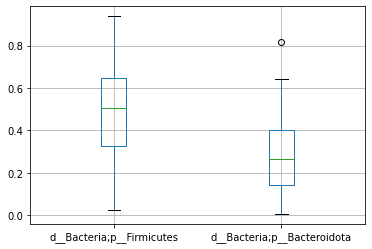

In [332]:
L2_table_df[['d__Bacteria;p__Firmicutes','d__Bacteria;p__Bacteroidota']].boxplot()
#plot(kind='box')

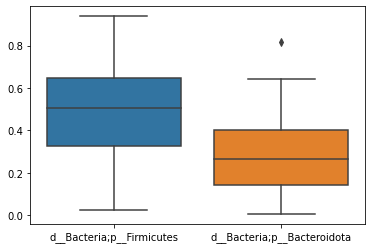

In [333]:
ax = sns.boxplot(data = L2_table_df[['d__Bacteria;p__Firmicutes','d__Bacteria;p__Bacteroidota']])
#ax.set_yscale('log')

In [405]:
metadata_API_df = metadata_API.to_dataframe()
for col in metadata_API_df.columns:
    print(col)

barcodesequence
linkerprimersequence
study
plate.sample.id
plate.well.id
primer.plate
primer.well.id
body-site
date_collected
time_collected
participant
redcap_event_name
age
participant-num
Children_status
Children_number
Living_other
Living_Situation
Years_Edu
Race_Ethnicity_other
Date_dx
Type_dx
Radiation
Chemotherapy
Surgery
Other
Type_tx_other
Previous_dx
Date_previous_dx
Type_previous_dx
Med_condition_status
Med_condition
Med_condition_dx
Med_condition_tx
Smoke_status
Smoke_amount
Smoke_paxperday
ETOH
cesd_1
cesd_2
cesd_3
cesd_4
cesd_5
cesd_6
cesd_7
cesd_8
cesd_9
cesd_10
cesd_11
cesd_12
cesd_13
cesd_14
cesd_15
cesd_16
cesd_17
cesd_18
cesd_19
cesd_20
stress_scale_1
stress_scale_2
stress_scale_3
stress_scale_4
stress_scale_4r
stress_scale_5
stress_scale_5r
stress_scale_6
stress_scale_7
stress_scale_7r
stress_scale_8
stress_scale_8r
stress_scale_9
stress_scale_10
promis_1
promis_2
promis_3
promis_4
promis_5
promis_6
promis_7
promis_8
promis_9
promis_10
promis_11
promis_12
promis_13


In [406]:
Firm_bac = metadata_API_df[['hcvsbc-cat', 'Radiation']].merge(L2_table_df[['d__Bacteria;p__Firmicutes','d__Bacteria;p__Bacteroidota']],
                                                         left_index=True,
                                                         right_index=True)
Firm_bac.head()

hcvsbc-cat Radiation  d__Bacteria;p__Firmicutes  d__Bacteria;p__Bacteroidota
1    1 - Yes         Y                   0.275414                     0.045337
3     2 - No         N                   0.325710                     0.494309
4     2 - No         N                   0.609838                     0.030278
6     2 - No         N                   0.247010                     0.302252
8     2 - No         N                   0.061673                     0.157054

In [415]:
metadata_API_df[['hcvsbc-cat','Chemotherapy-cat']]

hcvsbc-cat Chemotherapy-cat
sampleid                            
1           1 - Yes     Chemotherapy
3            2 - No  No Chemotherapy
4            2 - No  No Chemotherapy
6            2 - No  No Chemotherapy
8            2 - No  No Chemotherapy
10           2 - No  No Chemotherapy
12           2 - No  No Chemotherapy
14          1 - Yes     Chemotherapy
15           2 - No  No Chemotherapy
17          1 - Yes     Chemotherapy
19           2 - No  No Chemotherapy
21          1 - Yes     Chemotherapy
22          1 - Yes     Chemotherapy
23          1 - Yes     Chemotherapy
45          1 - Yes     Chemotherapy
46          1 - Yes     Chemotherapy
24          1 - Yes     Chemotherapy
25          1 - Yes     Chemotherapy
26           2 - No  No Chemotherapy
28          1 - Yes     Chemotherapy
29          1 - Yes     Chemotherapy
30          1 - Yes     Chemotherapy
31          1 - Yes  No Chemotherapy
32          1 - Yes     Chemotherapy
33          1 - Yes     Chemotherapy
34           2 - No  No Chemotherapy
36           2 - No  No Chemotherapy
38          1 - Yes     Chemotherapy
39           2 - No  No Chemotherapy
41          1 - Yes     Chemotherapy
42           2 - No  No Chemotherapy
43           2 - No  No Chemotherapy
44          1 - Yes     Chemotherapy
2               NaN              NaN
5               NaN              NaN
7               NaN              NaN
9               NaN              NaN
11              NaN              NaN
13              NaN              NaN
16              NaN              NaN
18              NaN              NaN
20              NaN              NaN
27              NaN              NaN
35              NaN              NaN
37              NaN              NaN
40              NaN              NaN

In [418]:
metadata_API_df.iloc[31][:20]

barcodesequence                    TACACGCTGATG
linkerprimersequence                         AA
study                   CU Denver BC Microbiome
plate.sample.id                            1046
plate.well.id                                C6
primer.plate                                  7
primer.well.id                               C6
body-site                                   gut
date_collected                        9/30/2019
time_collected                              NaN
participant                                  35
redcap_event_name                 event_1_arm_1
age                                          40
participant-num                            1046
Children_status                               1
Children_number                               2
Living_other                                NaN
Living_Situation                              2
Years_Edu                                     9
Race_Ethnicity_other                        NaN
Name: 43, dtype: object

In [423]:
metadata_API_df[metadata_API_df['participant-num']==1032][['hcvsbc-cat','Chemotherapy-cat']]

hcvsbc-cat Chemotherapy-cat
sampleid                            
31          1 - Yes  No Chemotherapy

We can see above that participant number 1032 answered incorrectly to the Chemotherapy question.

In [336]:
Firm_bac.dropna(inplace=True)

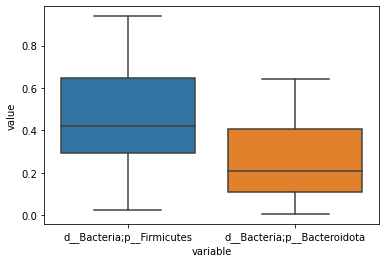

In [337]:
sns.boxplot(x="variable",y="value",data=pd.melt(Firm_bac[['d__Bacteria;p__Firmicutes','d__Bacteria;p__Bacteroidota']]))

Text(0, 0.5, '-log(Firmicutes)')

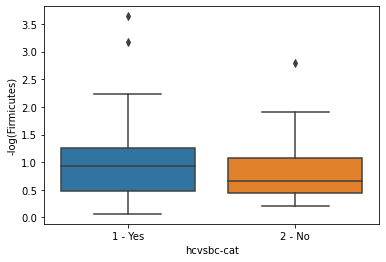

In [407]:
ax = sns.boxplot(x=Firm_bac['hcvsbc-cat'],
            y=Firm_bac['d__Bacteria;p__Firmicutes'].apply(lambda x: -1*np.log(x)))
ax.set_ylabel('-log(Firmicutes)')

In [412]:
ratio= Firm_bac['d__Bacteria;p__Bacteroidota'].divide(Firm_bac['d__Bacteria;p__Firmicutes'])
ratio_log = ratio.apply(lambda x: np.log(x))

In [413]:
ratio.head()

1    0.164612
3    1.517635
4    0.049650
6    1.223643
8    2.546573
dtype: float64

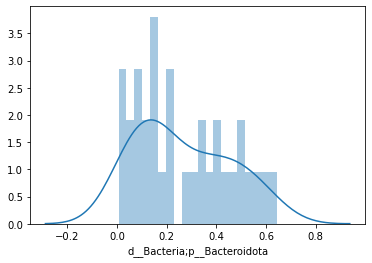

In [347]:
sns.distplot(Firm_bac['d__Bacteria;p__Bacteroidota'],bins=20)

Text(0.5, 0, 'Chemotherapy Group')

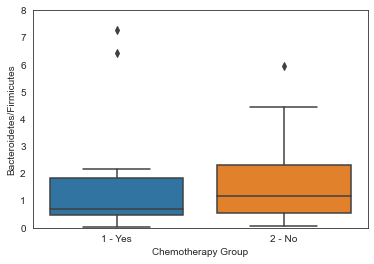

In [764]:
ax = sns.boxplot(x=Firm_bac['hcvsbc-cat'],
            y=ratio)
ax.set_ylabel('Bacteroidetes/Firmicutes')
ax.set_ylim(0,8)
ax.set_xlabel('Chemotherapy Group')

Text(0.5, 0, 'Chemotherapy Group')

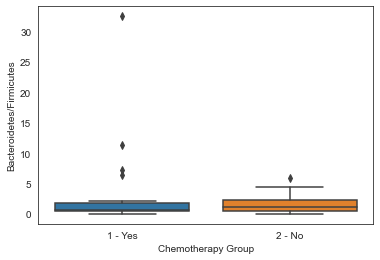

In [765]:
ax = sns.boxplot(x=Firm_bac['hcvsbc-cat'],
            y=ratio)
ax.set_ylabel('Bacteroidetes/Firmicutes')
ax.set_xlabel('Chemotherapy Group')

In [424]:
stats.kruskal(Firm_bac[Firm_bac['hcvsbc-cat']=='1 - Yes']['d__Bacteria;p__Bacteroidota'],
              Firm_bac[Firm_bac['hcvsbc-cat']=='2 - No']['d__Bacteria;p__Bacteroidota'])

KruskalResult(statistic=0.10747456877486172, pvalue=0.7430378274448415)

In [425]:
stats.kruskal(ratio[Firm_bac['hcvsbc-cat']=='1 - Yes'],
              ratio[Firm_bac['hcvsbc-cat']=='2 - No'])

KruskalResult(statistic=0.5307386112339572, pvalue=0.4662964974489522)

In [426]:
stats.kruskal(Firm_bac[Firm_bac['hcvsbc-cat']=='1 - Yes']['d__Bacteria;p__Firmicutes'],
              Firm_bac[Firm_bac['hcvsbc-cat']=='2 - No']['d__Bacteria;p__Firmicutes'])

KruskalResult(statistic=0.42989827509951795, pvalue=0.5120388673177018)

In [355]:
Firm_bac.columns

Index(['Chemotherapy-cat', 'Radiation', 'd__Bacteria;p__Firmicutes',
       'd__Bacteria;p__Bacteroidota'],
      dtype='object')

### Gram-/Gram+ ratio

In [356]:
grampos = L2_table_df[['d__Bacteria;p__Actinobacteriota','d__Bacteria;p__Firmicutes']]
grampos['positive'] = grampos.sum(axis=1)

/opt/anaconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [427]:
grams = grampos.merge(metadata_API_df[['hcvsbc-cat', 'Radiation']],
             left_index=True,
             right_index=True)
grams.head()

d__Bacteria;p__Actinobacteriota  ...  Radiation
1                          0.024366  ...          Y
10                         0.023148  ...          N
11                         0.009510  ...        NaN
12                         0.008284  ...          N
13                         0.003098  ...        NaN

[5 rows x 5 columns]

In [358]:
L2_table_df.columns

Index(['d__Archaea;p__Euryarchaeota', 'd__Archaea;p__Thermoplasmatota',
       'd__Bacteria;__', 'd__Bacteria;p__Actinobacteriota',
       'd__Bacteria;p__Bacteroidota', 'd__Bacteria;p__Campilobacterota',
       'd__Bacteria;p__Cyanobacteria', 'd__Bacteria;p__Desulfobacterota',
       'd__Bacteria;p__Elusimicrobiota', 'd__Bacteria;p__Firmicutes',
       'd__Bacteria;p__Fusobacteriota', 'd__Bacteria;p__Proteobacteria',
       'd__Bacteria;p__Synergistota', 'd__Bacteria;p__Verrucomicrobiota',
       'd__Eukaryota;p__Basidiomycota', 'depth'],
      dtype='object')

In [359]:
negbac = ['d__Bacteria;p__Bacteroidota', 'd__Bacteria;p__Campilobacterota',
       'd__Bacteria;p__Cyanobacteria', 'd__Bacteria;p__Desulfobacterota',
       'd__Bacteria;p__Elusimicrobiota',
       'd__Bacteria;p__Fusobacteriota', 'd__Bacteria;p__Proteobacteria',
       'd__Bacteria;p__Synergistota', 'd__Bacteria;p__Verrucomicrobiota']

gramnegs = L2_table_df[negbac]
gramnegs['negative'] = gramnegs.sum(axis=1)

/opt/anaconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [429]:
grams = grams.merge(gramnegs['negative'],
             left_index=True,
             right_index=True)

Text(0, 0.5, 'gram positive/gram negative')

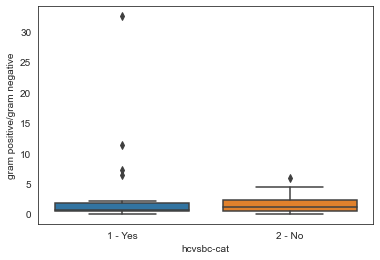

In [757]:
ratio = grams['positive']/grams['negative']
ax = sns.boxplot(x=grams['hcvsbc-cat'],y=ratio)
ax.set_ylabel("gram positive/gram negative")

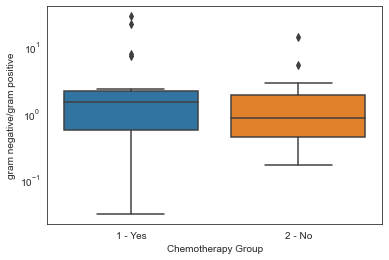

In [760]:
revratio = grams['negative']/grams['positive']
ax = sns.boxplot(x=grams['hcvsbc-cat'],y=revratio)
ax.set_ylabel("gram negative/gram positive")
ax.set_xlabel('Chemotherapy Group')
ax.set_yscale('log')

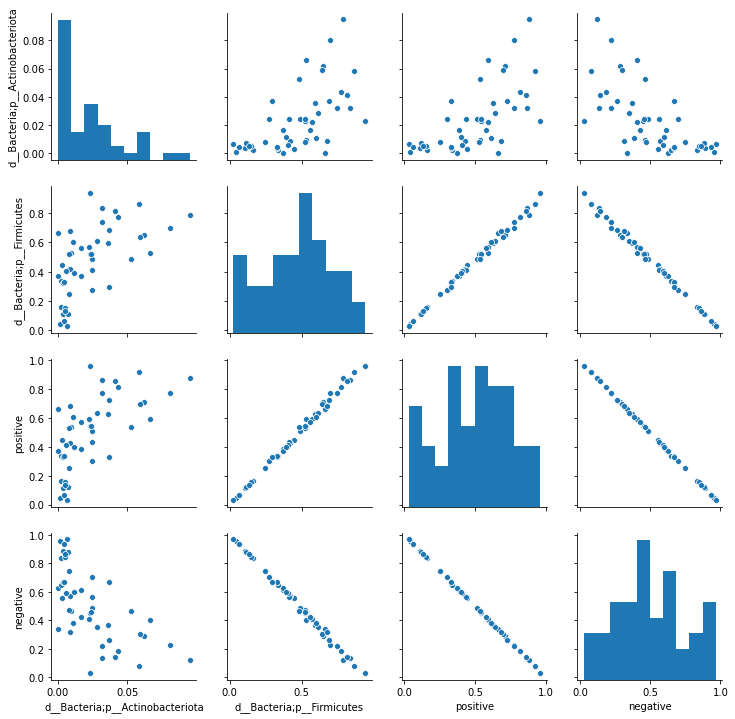

In [365]:
sns.pairplot(data=grams)

In [432]:
stats.kruskal(ratio[grams['hcvsbc-cat']=='1 - Yes'],
              ratio[grams['hcvsbc-cat']=='2 - No'])

KruskalResult(statistic=0.42989827509951795, pvalue=0.5120388673177018)

### Other Phyla

In [441]:
L2_table_df = L2_table_df.merge(metadata_API_df['hcvsbc-cat'],
                  left_index=True,
                  right_index=True)

In [440]:
L2_table_df.drop(['hcvsbc-cat_x','hcvsbc-cat_y'],inplace=True,axis=1)

/opt/anaconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/anaconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/anaconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/opt/ana

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x137be9828>,
      dtype=object)

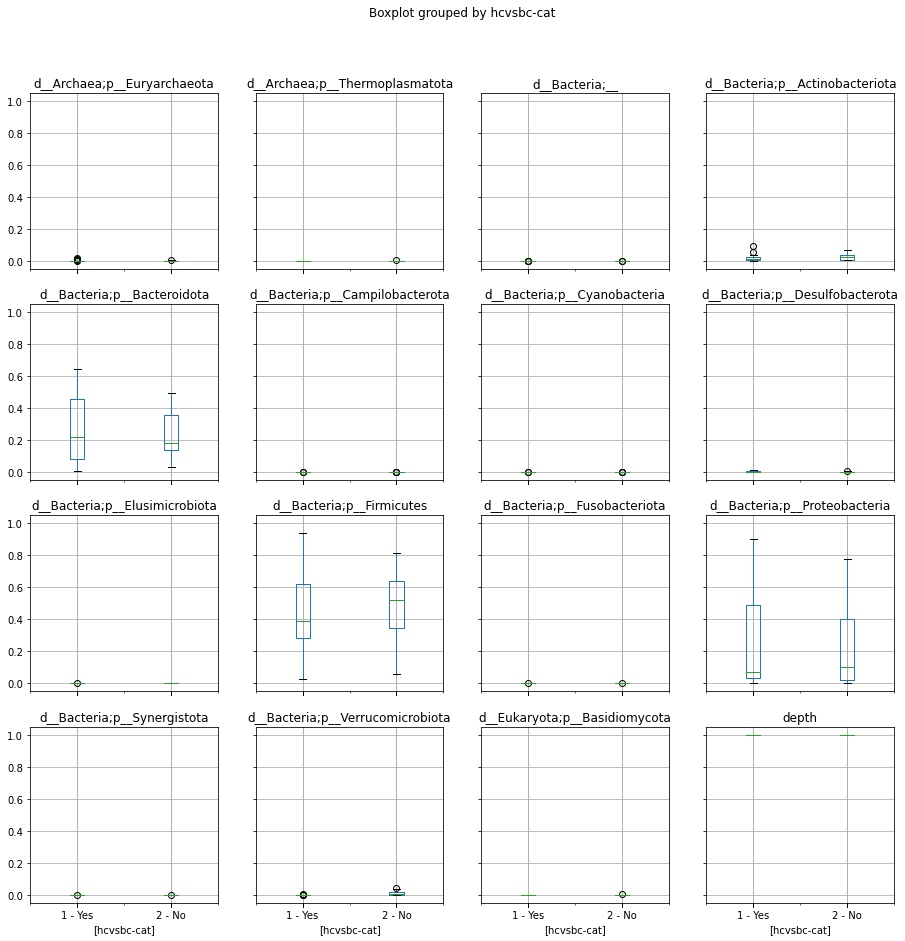

In [442]:
L2_table_df.boxplot(by='hcvsbc-cat', figsize=(15,15))

Taking log of all values in an attempt to make closer to a normal distribution - did not use

/opt/anaconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/anaconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/anaconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/opt/ana

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1333f5748>,
      dtype=object)

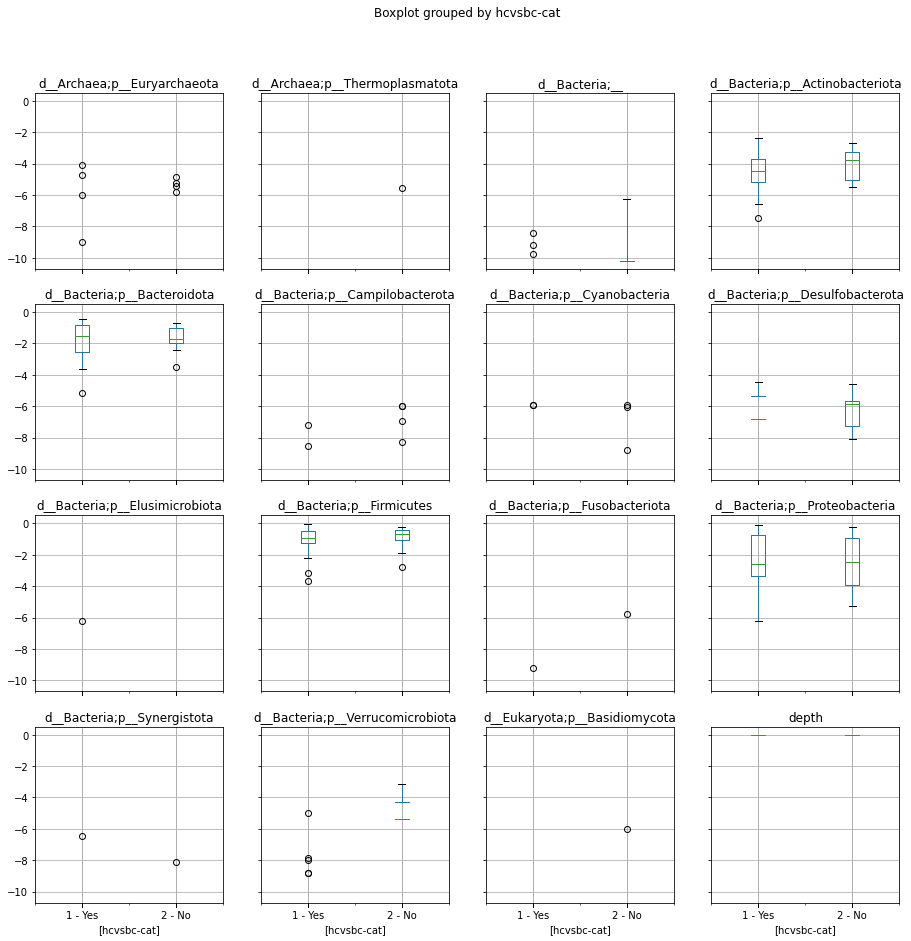

In [444]:
L2_table_df_log = L2_table_df.drop(['hcvsbc-cat','Chemotherapy-cat'],axis=1).apply(lambda x: np.log(x))
L2_table_df_log = L2_table_df_log.merge(L2_table_df['hcvsbc-cat'],left_index=True,right_index=True)

L2_table_df_log.boxplot(by='hcvsbc-cat', figsize=(15,15))

In [445]:
stats.kruskal(L2_table_df[L2_table_df['hcvsbc-cat']=='1 - Yes']['d__Bacteria;p__Proteobacteria'],
              L2_table_df[L2_table_df['hcvsbc-cat']=='2 - No']['d__Bacteria;p__Proteobacteria'])

KruskalResult(statistic=0.16054842989827023, pvalue=0.688652091976238)

In [446]:
stats.kruskal(L2_table_df[L2_table_df['hcvsbc-cat']=='1 - Yes']['d__Bacteria;p__Verrucomicrobiota'],
              L2_table_df[L2_table_df['hcvsbc-cat']=='2 - No']['d__Bacteria;p__Verrucomicrobiota'])

KruskalResult(statistic=7.57924538845049, pvalue=0.005904415269352158)

In [676]:
stats.spearmanr(metadata_API_df['fact_c_total'],
                L2_table_df['d__Bacteria;p__Verrucomicrobiota'],
                nan_policy='omit')

SpearmanrResult(correlation=-0.19436464410841328, pvalue=0.2784243415055946)

In [448]:
stats.kruskal(L2_table_df[L2_table_df['hcvsbc-cat']=='1 - Yes']['d__Bacteria;p__Actinobacteriota'],
              L2_table_df[L2_table_df['hcvsbc-cat']=='2 - No']['d__Bacteria;p__Actinobacteriota'])

KruskalResult(statistic=0.7642636001769176, pvalue=0.38199752465388903)

In [755]:
sns.set_style('white')

Text(0.5, 0, 'Cancer Group')

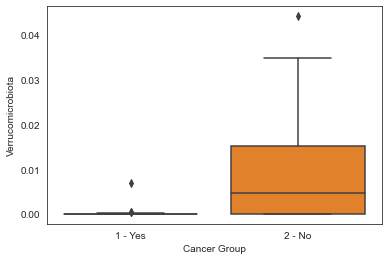

In [756]:
ax = sns.boxplot(x=L2_table_df['hcvsbc-cat'], y=L2_table_df['d__Bacteria;p__Verrucomicrobiota'])
ax.set_ylabel('Verrucomicrobiota')
ax.set_xlabel('Cancer Group')

In [690]:
for col in L2_table_df.drop(['depth','Chemotherapy-cat','hcvsbc-cat'],axis=1).columns:
    print(col)
    print(stats.spearmanr(L2_table_df[col],
                         metadata_API_df['fact_c_total'],
                         nan_policy='omit'))

d__Archaea;p__Euryarchaeota
SpearmanrResult(correlation=-0.19141399942899842, pvalue=0.2859279177590003)
d__Archaea;p__Thermoplasmatota
SpearmanrResult(correlation=0.0, pvalue=1.0)
d__Bacteria;__
SpearmanrResult(correlation=-0.30269739369392484, pvalue=0.08685110880912789)
d__Bacteria;p__Actinobacteriota
SpearmanrResult(correlation=0.014544847880777695, pvalue=0.9359698662241628)
d__Bacteria;p__Bacteroidota
SpearmanrResult(correlation=-0.24910141772826166, pvalue=0.1621273545123674)
d__Bacteria;p__Campilobacterota
SpearmanrResult(correlation=-0.20272858476317693, pvalue=0.2578528599448588)
d__Bacteria;p__Cyanobacteria
SpearmanrResult(correlation=-0.12854928893612522, pvalue=0.47587540565836994)
d__Bacteria;p__Desulfobacterota
SpearmanrResult(correlation=-0.3163543516495738, pvalue=0.0728724308074513)
d__Bacteria;p__Elusimicrobiota
SpearmanrResult(correlation=0.2785954125855233, pvalue=0.11642329721211125)
d__Bacteria;p__Firmicutes
SpearmanrResult(correlation=-0.023572684496432815, pval

In [958]:
for col in L2_table_df.drop(['depth','Chemotherapy-cat','hcvsbc-cat'],axis=1).columns:
    temp_df = pd.concat([L2_table_df[col],
                         metadata_API_df['fact_c_total']],
                       axis=1)
    print(col)
    print(stats.spearmanr(temp_df[col],
                         temp_df['fact_c_total'],
                         nan_policy='omit'))

d__Archaea;p__Euryarchaeota
SpearmanrResult(correlation=0.0017785272885388935, pvalue=0.9921625815743479)
d__Archaea;p__Thermoplasmatota
SpearmanrResult(correlation=0.16715724755131395, pvalue=0.35248264293642173)
d__Bacteria;__
SpearmanrResult(correlation=0.4306259197374796, pvalue=0.012361201508194159)
d__Bacteria;p__Actinobacteriota
SpearmanrResult(correlation=0.22954110506100894, pvalue=0.19878936366579184)
d__Bacteria;p__Bacteroidota
SpearmanrResult(correlation=0.2221850900408455, pvalue=0.21396131746966868)
d__Bacteria;p__Campilobacterota
SpearmanrResult(correlation=0.10512397170158475, pvalue=0.5604163111620062)
d__Bacteria;p__Cyanobacteria
SpearmanrResult(correlation=-0.014467767555163108, pvalue=0.9363085055454798)
d__Bacteria;p__Desulfobacterota
SpearmanrResult(correlation=0.44169883520248804, pvalue=0.01007038333399734)
d__Bacteria;p__Elusimicrobiota
SpearmanrResult(correlation=-0.06500559626995543, pvalue=0.7192880629050202)
d__Bacteria;p__Firmicutes
SpearmanrResult(correla

/opt/anaconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [775]:
df = Artifact.load('L2p-filtered.qza')

df = df.view(pd.DataFrame)

In [785]:
df['depth'] = df.sum(axis=1)

KeyError: 'd'

In [790]:
for col in df.columns:
    df[col] = df[col]/df['depth']

In [791]:
df['clr_Desulfobacterota'] = clr(df['d__Bacteria;p__Desulfobacterota'])

In [792]:
df.head()

d__Archaea;p__Euryarchaeota  ...  clr_Desulfobacterota
1                      0.000199  ...             -1.165742
10                     0.005373  ...              2.172245
12                     0.000022  ...             -3.349271
14                     0.000137  ...             -3.740513
15                     0.002974  ...              1.588806

[5 rows x 17 columns]

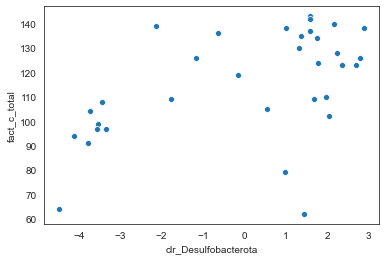

In [794]:
sns.scatterplot(df['clr_Desulfobacterota'],
          metadata_API_df['fact_c_total'])

In [802]:
stats.spearmanr(df['clr_Desulfobacterota'],
              metadata_API_df['fact_c_total'].dropna(),
               nan_policy='omit')

SpearmanrResult(correlation=0.028086602804260383, pvalue=0.8766995664428058)

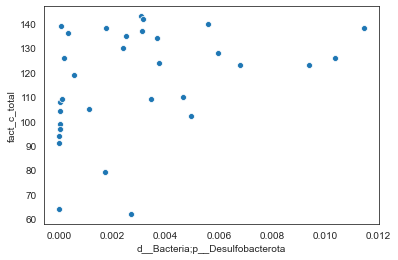

In [809]:
sns.scatterplot(df['d__Bacteria;p__Desulfobacterota'],
               metadata_API_df['fact_c_total'].dropna())
               #nan_policy='omit')

In [811]:
stats.spearmanr(df['d__Bacteria;p__Desulfobacterota'],
               metadata_API_df['fact_c_total'].dropna(),
               nan_policy='omit')

SpearmanrResult(correlation=0.028086602804260383, pvalue=0.8766995664428058)

In [824]:
temp = pd.concat([df['d__Bacteria;p__Desulfobacterota'],
                metadata_API_df['fact_c_total']],
                axis=1)
temp.rename({'d__Bacteria;p__Desulfobacterota': 'pseudo_Desulfo'},
            axis=1,
            inplace=True)

/opt/anaconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [826]:
temp = pd.concat([temp, L2_table_df['d__Bacteria;p__Desulfobacterota']], axis=1)

In [827]:
temp.head()

pseudo_Desulfo  fact_c_total  d__Bacteria;p__Desulfobacterota
1         0.000199         126.0                         0.000000
10        0.005612         140.0                         0.005590
11             NaN           NaN                         0.004543
12        0.000022          97.0                         0.000000
13             NaN           NaN                         0.000000

In [829]:
temp['Desulfobacterota+0.0000001']= temp['d__Bacteria;p__Desulfobacterota'].apply(lambda x: x+0.0000001)

In [830]:
temp.head()

pseudo_Desulfo  ...  Desulfobacterota+0.0000001
1         0.000199  ...                1.000000e-07
10        0.005612  ...                5.590029e-03
11             NaN  ...                4.543327e-03
12        0.000022  ...                1.000000e-07
13             NaN  ...                1.000000e-07

[5 rows x 4 columns]

In [959]:
stats.spearmanr(temp['fact_c_total'],
               temp['Desulfobacterota+0.0000001'],
               nan_policy='omit')

SpearmanrResult(correlation=0.44169883520248804, pvalue=0.01007038333399734)

### Transforming the relative abundances - arcsin sqrt worked best/was chosen for Emily's hierarchical linear regression

In [841]:
temp['clr_Desulfobacterota'] = clr(temp['Desulfobacterota+0.0000001'])
temp['sqr_Desulfobacterota'] = np.sqrt(temp['d__Bacteria;p__Desulfobacterota'])
temp['arcsinsqrt_Desulfobacterota'] = np.arcsin(np.sqrt(temp['d__Bacteria;p__Desulfobacterota']))

In [834]:
stats.spearmanr(metadata_API_df['fact_c_total'],
               temp['clr_Desulfobacterota'],
               nan_policy='omit')

SpearmanrResult(correlation=-0.3163543516495738, pvalue=0.0728724308074513)

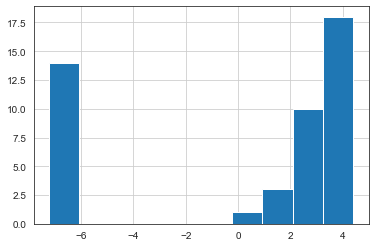

In [836]:
temp['clr_Desulfobacterota'].hist()

I don't trust the clr here. Not going to use it. Will use arcsine sqrt transformation

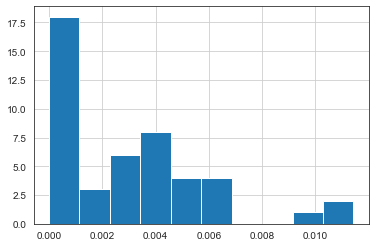

In [844]:
temp['d__Bacteria;p__Desulfobacterota'].hist()

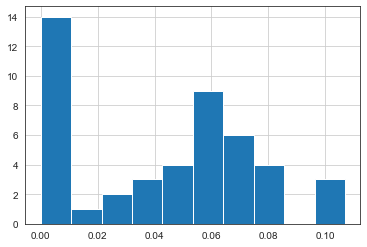

In [839]:
temp['sqr_Desulfobacterota'].hist()

It isn't perfect, but this one seems to be the best:

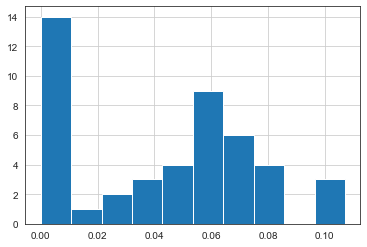

In [842]:
temp['arcsinsqrt_Desulfobacterota'].hist()

In [853]:
temp = pd.concat([temp, 
                  of_interest['Akkermansia']],
                axis=1)

In [854]:
temp['arcsinsqrt_Akkermansia'] = np.arcsin(np.sqrt(temp['Akkermansia']))

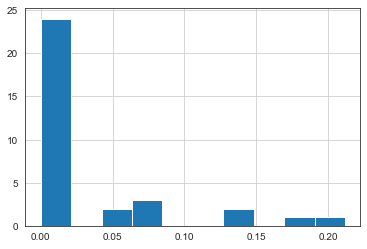

In [855]:
temp['arcsinsqrt_Akkermansia'].hist()

In [861]:
HLRtable = temp[['arcsinsqrt_Akkermansia','arcsinsqrt_Desulfobacterota']].dropna()
HLRtable.to_csv('HLR-abundances-nona.csv')

In [862]:
HLRtable

arcsinsqrt_Akkermansia  arcsinsqrt_Desulfobacterota
1                 0.000000                     0.000000
10                0.000000                     0.074836
12                0.000000                     0.000000
14                0.000000                     0.000000
15                0.049522                     0.055874
17                0.000000                     0.076951
19                0.000000                     0.055483
21                0.019778                     0.070399
22                0.000000                     0.000000
23                0.000000                     0.000000
24                0.077451                     0.097059
25                0.000000                     0.032766
26                0.080689                     0.060465
28                0.000000                     0.000000
29                0.000000                     0.082494
3                 0.000000                     0.101934
30                0.000000                     0.051860
31                0.000000                     0.000000
32                0.000000                     0.000000
33                0.000000                     0.000000
34                0.211855                     0.048893
36                0.000000                     0.055822
38                0.012139                     0.058608
39                0.188049                     0.023137
4                 0.060837                     0.017771
41                0.018734                     0.068065
42                0.144005                     0.061122
43                0.134596                     0.000000
44                0.000000                     0.041390
45                0.000000                     0.107104
46                0.012082                     0.000000
6                 0.076742                     0.050167
8                 0.000000                     0.041818

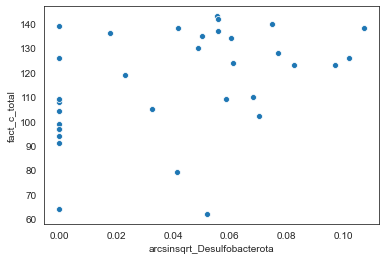

In [843]:
sns.scatterplot(temp['arcsinsqrt_Desulfobacterota'],
                metadata_API_df['fact_c_total'])

In [957]:
desulf_temp = pd.concat([temp['arcsinsqrt_Desulfobacterota'],
                        metadata_API_df['fact_c_total']],
                       axis=1)
stats.spearmanr(desulf_temp['arcsinsqrt_Desulfobacterota'],
                desulf_temp['fact_c_total'],
                nan_policy='omit')

/opt/anaconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


SpearmanrResult(correlation=0.44169883520248804, pvalue=0.01007038333399734)

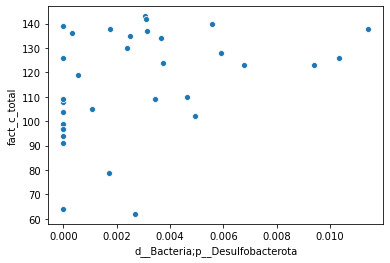

In [713]:
sns.scatterplot(L2_table_df['d__Bacteria;p__Desulfobacterota'],
                metadata_API_df['fact_c_total'])

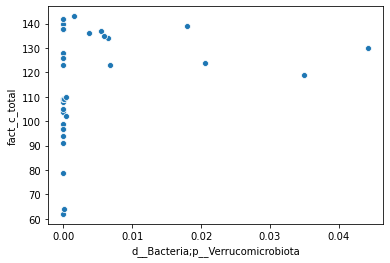

In [723]:
sns.scatterplot(L2_table_df['d__Bacteria;p__Verrucomicrobiota'],
              metadata_API_df['fact_c_total'])

In [727]:
L2_table_df[L2_table_df['d__Bacteria;p__Fusobacteriota']==L2_table_df['d__Bacteria;p__Fusobacteriota'].max()]

d__Archaea;p__Euryarchaeota  ...  hcvsbc-cat
27                          0.0  ...         NaN

[1 rows x 18 columns]

## Genus level analyses

In [463]:
! qiime taxa collapse \
--i-table noMito_noChloro-filtered-table.qza \
--i-taxonomy taxonomy-silva.qza \
--p-level 6 \
--o-collapsed-table tax-L6-table.qza

Saved FeatureTable[Frequency] to: tax-L6-table.qza


In [465]:
L6_table = Artifact.load('tax-L6-table.qza')
L6_df = L6_table.view(pd.DataFrame)

In [466]:
L6_df.head()

d__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobacterium  ...  d__Eukaryota;p__Basidiomycota;c__Microbotryomycetes;o__Sporidiobolales;f__Sporidiobolaceae;g__Rhodotorula
1                                                 0.0                                                                ...                                                0.0                                                        
10                                                0.0                                                                ...                                                0.0                                                        
11                                                0.0                                                                ...                                                0.0                                                        
12                                                0.0                                                                ...                                                0.0                                                        
13                                                0.0                                                                ...                                                0.0                                                        

[5 rows x 314 columns]

Convert to relative abundances

In [480]:
L6_df['depth'] = L6_df.sum(axis=1)

In [481]:
for col in L6_df.columns:
    L6_df[col] = L6_df[col]/L6_df['depth']

In [482]:
L6_df.head()

d__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobacterium  ...  depth
1                                                 0.0                                                                ...    1.0
10                                                0.0                                                                ...    1.0
11                                                0.0                                                                ...    1.0
12                                                0.0                                                                ...    1.0
13                                                0.0                                                                ...    1.0

[5 rows x 315 columns]

In [509]:
genuses = ['Lactobacillus', 'Faecalibacterium', 'Veillonella', 'Enterococcus', 'Akkermansia','Helicobacter','Klebsiella',
          'Bifidobacterium', 'Proteus', 'Escherichia']
for col in L6_df.columns:
    for genus in genuses:
        if genus in col:
            print(col)

d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium
d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus
d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus
d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Faecalibacterium
d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Selenomonadaceae;g__uncultured
d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Veillonellaceae;__
d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Veillonellaceae;g__Allisonella
d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Veillonellaceae;g__Anaeroglobus
d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Veillonellaceae;g__Dialister
d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Sel

In [510]:
interest = ['d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus',
            'd__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus',
            'd__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Faecalibacterium',
            'd__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Veillonellaceae;g__Veillonella',
            'd__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia',
            'd__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium',
            'd__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Morganellaceae;g__Proteus',
            'd__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia-Shigella']

of_interest = L6_df[interest]

In [511]:
of_interest = of_interest.merge(metadata_API_df['hcvsbc-cat'],
                 left_index=True,
                 right_index=True)

In [512]:
rename_dict = {x:x.split('g__')[1] for x in interest}
print(rename_dict)

{'d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus': 'Enterococcus', 'd__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus': 'Lactobacillus', 'd__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Faecalibacterium': 'Faecalibacterium', 'd__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Veillonellaceae;g__Veillonella': 'Veillonella', 'd__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia': 'Akkermansia', 'd__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium': 'Bifidobacterium', 'd__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Morganellaceae;g__Proteus': 'Proteus', 'd__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia-Shigella': 'Escherichia-Shigella'}


In [513]:
of_interest = of_interest.rename(columns=rename_dict)

/opt/anaconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/anaconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/anaconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/opt/ana

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12e141d68>,
      dtype=object)

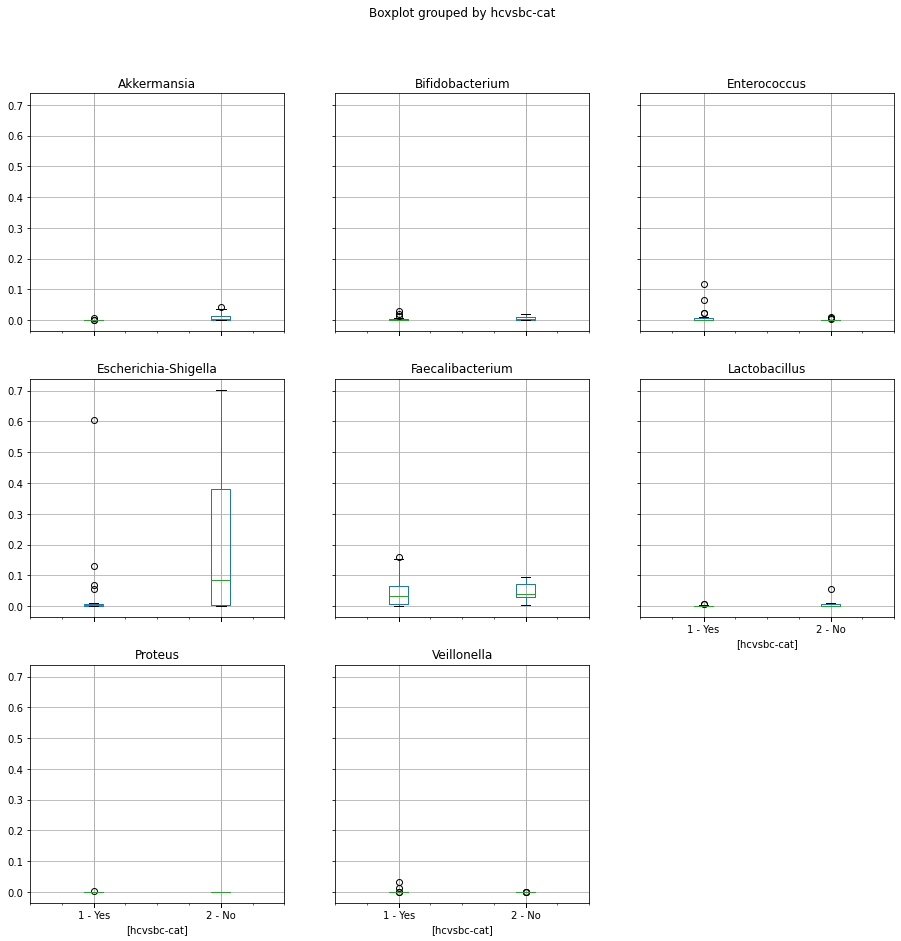

In [514]:
of_interest.boxplot(by='hcvsbc-cat', figsize=(15,15))

In [515]:
for genus in [x.split('g__')[1] for x in interest]:
    print(genus)
    print(stats.kruskal(of_interest[of_interest['hcvsbc-cat']=='1 - Yes'][genus],
                        of_interest[of_interest['hcvsbc-cat']=='2 - No'][genus]))
    print('\n')

Enterococcus
KruskalResult(statistic=2.4581577783467816, pvalue=0.11691583352821955)


Lactobacillus
KruskalResult(statistic=1.5637936540192194, pvalue=0.2111106197687272)


Faecalibacterium
KruskalResult(statistic=0.6423010559994979, pvalue=0.42287877775871885)


Veillonella
KruskalResult(statistic=0.031795736480778714, pvalue=0.8584767063461516)


Akkermansia
KruskalResult(statistic=5.739074803467635, pvalue=0.016591529897758323)


Bifidobacterium
KruskalResult(statistic=1.6331790329917222, pvalue=0.201263906892361)


Proteus
KruskalResult(statistic=0.7368421052628945, pvalue=0.3906743460236528)


Escherichia-Shigella
KruskalResult(statistic=2.93591024766468, pvalue=0.08662981956596605)




In [961]:
of_interest = pd.concat([of_interest, metadata_API_df['fact_c_total']],
                         axis=1)

/opt/anaconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [962]:
for genus in [x.split('g__')[1] for x in interest]:
    print(genus)
    print(stats.spearmanr(of_interest[genus],
                          of_interest['fact_c_total'],
                          nan_policy='omit'))
    print('\n')

Enterococcus
SpearmanrResult(correlation=-0.29431186457098807, pvalue=0.09640117989362802)


Lactobacillus
SpearmanrResult(correlation=0.2021652504448942, pvalue=0.25920603906904255)


Faecalibacterium
SpearmanrResult(correlation=0.15106170381438944, pvalue=0.40138275820910174)


Veillonella
SpearmanrResult(correlation=-0.0614966889187742, pvalue=0.7338775893233669)


Akkermansia
SpearmanrResult(correlation=0.23961809313693505, pvalue=0.17924329028072067)


Bifidobacterium
SpearmanrResult(correlation=0.007763008814461379, pvalue=0.9658002657209135)


Proteus
SpearmanrResult(correlation=-0.09286513752850775, pvalue=0.6072429319229697)


Escherichia-Shigella
SpearmanrResult(correlation=-0.012047185861164275, pvalue=0.9469481940711798)




Text(0.5, 0, 'Chemotherapy Group')

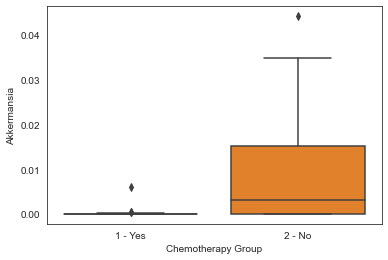

In [766]:
ax = sns.boxplot(x='hcvsbc-cat',y='Akkermansia',data=of_interest)
ax.set_xlabel('Chemotherapy Group')

In [661]:
stats.spearmanr(metadata_API_df['fact_c_total'], of_interest['Akkermansia'], nan_policy='omit')

SpearmanrResult(correlation=-0.2788803905662977, pvalue=0.11603459866947174)

In [672]:
stats.pearsonr(metadata_API_df['fact_c_total'].dropna(),
               of_interest['Akkermansia'][metadata_API_df['fact_c_total'].isna()==False])

(0.11011729813439183, 0.5418323567680615)

In [860]:
of_interest['Akkermansia'][metadata_API_df['fact_c_total'].isna()==False]

1     0.000000
10    0.000000
12    0.000000
14    0.000000
15    0.002450
17    0.000000
19    0.000000
21    0.000391
22    0.000000
23    0.000000
24    0.005987
25    0.000000
26    0.006497
28    0.000000
29    0.000000
3     0.000000
30    0.000000
31    0.000000
32    0.000000
33    0.000000
34    0.044215
36    0.000000
38    0.000147
39    0.034948
4     0.003697
41    0.000351
42    0.020595
43    0.018007
44    0.000000
45    0.000000
46    0.000146
6     0.005878
8     0.000000
Name: Akkermansia, dtype: float64

## Perform ANCOM analysis 
Perform ANCOM at the phylum and genus levels. Use the collapsed rarefied feature tables that were created for the biplots above using the `qiime taxa collapse` command. Note that ANCOM is performed one meta data varaible at a time and it requires the variable to be categorical. 

#### Make a feature table with pseudo counts
This is a necessary intermediate step 

In [179]:
! qiime composition add-pseudocount \
--i-table tax-L2-table.qza \
--o-composition-table tax-L2-table-pseudo.qza

Saved FeatureTable[Composition] to: tax-L2-table-pseudo.qza


In [210]:
L2p = Artifact.load('tax-L2-table-pseudo.qza')

In [212]:
#turn it into a dataframe and then remove from the feature table all the time 2
L2p = L2p.view(pd.DataFrame)
L2p = L2p[metadata_API_df['Chemotherapy-cat'].isna()==False]

/opt/anaconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [213]:
#turn back into an api artifact
L2p = Artifact.import_data("FeatureTable[Composition]", L2p)

In [216]:
#export its data to be usable by the CLI
L2p.export_data('L2p')

In [217]:
#turn it into a CLI-usable artifact
! qiime tools import \
--type FeatureTable[Composition] \
--input-path L2p/feature-table.biom \
--output-path L2p-filtered.qza

Imported L2p/feature-table.biom as BIOMV210DirFmt to L2p-filtered.qza


### Perform ANCOM 

In [449]:
! qiime composition ancom \
--i-table L2p-filtered.qza \
--m-metadata-file Categorical-meta-noNA.tsv \
--m-metadata-column hcvsbc-cat \
--o-visualization ANCOM-L2-hcvsbc.qzv

Saved Visualization to: ANCOM-L2-hcvsbc.qzv


In [651]:
viz = Visualization.load('ANCOM-L2-hcvsbc.qzv')
viz

<visualization: Visualization uuid: 976503f4-144c-40cd-9d99-e6e45620ee3e>

#### Take the .qzv file to qiime 2 view 

## Level 3 ANCOM steps

In [222]:
! qiime taxa collapse \
--i-table noMito_noChloro-filtered-table.qza \
--i-taxonomy taxonomy-silva.qza \
--p-level 3 \
--o-collapsed-table tax-L3-table.qza

Saved FeatureTable[Frequency] to: tax-L3-table.qza


In [234]:
! qiime composition add-pseudocount \
--i-table tax-L3-table.qza \
--o-composition-table tax-L3-table-pseudo.qza

Saved FeatureTable[Composition] to: tax-L3-table-pseudo.qza


In [235]:
L3p = Artifact.load('tax-L3-table-pseudo.qza')

#turn it into a dataframe and then remove from the feature table all the time 3
L3p = L3p.view(pd.DataFrame)
L3p = L3p[metadata_API_df['Chemotherapy-cat'].isna()==False]

#turn back into an api artifact
L3p = Artifact.import_data("FeatureTable[Composition]", L3p)

#export its data to be usable by the CLI
L3p.export_data('L3p')

/opt/anaconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [236]:
#turn it into a CLI-usable artifact
! qiime tools import \
--type FeatureTable[Composition] \
--input-path L3p/feature-table.biom \
--output-path L3p-filtered.qza

Imported L3p/feature-table.biom as BIOMV210DirFmt to L3p-filtered.qza


In [241]:
L3p_new = Artifact.load('L3p-filtered.qza')
L3p_new.view(pd.DataFrame)

d__Archaea;p__Euryarchaeota;c__Methanobacteria  ...  d__Eukaryota;p__Basidiomycota;c__Microbotryomycetes
1                                              1.0  ...                                                1.0  
10                                           225.0  ...                                                1.0  
12                                             1.0  ...                                                1.0  
14                                             9.0  ...                                                1.0  
15                                           227.0  ...                                                1.0  
17                                             1.0  ...                                                1.0  
19                                             1.0  ...                                                1.0  
21                                           833.0  ...                                                1.0  
22                                             1.0  ...                                                1.0  
23                                             1.0  ...                                                1.0  
24                                           151.0  ...                                                1.0  
25                                             1.0  ...                                                1.0  
26                                             1.0  ...                                              114.0  
28                                             1.0  ...                                                1.0  
29                                             1.0  ...                                                1.0  
3                                              1.0  ...                                                1.0  
30                                             1.0  ...                                                1.0  
31                                             1.0  ...                                                1.0  
32                                             1.0  ...                                                1.0  
33                                             1.0  ...                                                1.0  
34                                             1.0  ...                                                1.0  
36                                             1.0  ...                                                1.0  
38                                             1.0  ...                                                1.0  
39                                           394.0  ...                                                1.0  
4                                            242.0  ...                                                1.0  
41                                             1.0  ...                                                1.0  
42                                             1.0  ...                                                1.0  
43                                             1.0  ...                                                1.0  
44                                           581.0  ...                                                1.0  
45                                             1.0  ...                                                1.0  
46                                             1.0  ...                                                1.0  
6                                              1.0  ...                                                1.0  
8                                              1.0  ...                                                1.0  

[33 rows x 24 columns]

In [451]:
! qiime composition ancom \
--i-table L3p-filtered.qza \
--m-metadata-file Categorical-meta-noNA.tsv \
--m-metadata-column hcvsbc-cat \
--o-visualization ANCOM-L3-hcvsbc.qzv

Saved Visualization to: ANCOM-L3-hcvsbc.qzv


In [452]:
viz = Visualization.load('ANCOM-L3-hcvsbc.qzv')
viz

<visualization: Visualization uuid: 88835d64-7d79-4e2c-895b-63ce311aeabf>

### Genus Level ANCOM

In [500]:
! qiime composition add-pseudocount \
--i-table tax-L6-table.qza \
--o-composition-table tax-L6-table-pseudo.qza

Saved FeatureTable[Composition] to: tax-L6-table-pseudo.qza


In [501]:
L6p = Artifact.load('tax-L6-table-pseudo.qza')

#turn it into a dataframe and then remove from the feature table all the time 3
L6p = L6p.view(pd.DataFrame)
L6p = L6p[metadata_API_df['hcvsbc-cat'].isna()==False]

#turn back into an api artifact
L6p = Artifact.import_data("FeatureTable[Composition]", L6p)

#export its data to be usable by the CLI
L6p.export_data('L6p')

/opt/anaconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [502]:
#turn it into a CLI-usable artifact
! qiime tools import \
--type FeatureTable[Composition] \
--input-path L6p/feature-table.biom \
--output-path L6p-filtered.qza

Imported L6p/feature-table.biom as BIOMV210DirFmt to L6p-filtered.qza


In [503]:
! qiime composition ancom \
--i-table L6p-filtered.qza \
--m-metadata-file Categorical-meta-noNA.tsv \
--m-metadata-column hcvsbc-cat \
--o-visualization ANCOM-L6-hcvsbc.qzv

Saved Visualization to: ANCOM-L6-hcvsbc.qzv


In [504]:
viz = Visualization.load('ANCOM-L6-hcvsbc.qzv')
viz

<visualization: Visualization uuid: 2a8f06eb-ee7e-4ad8-8612-6cfcd4b6bcfe>

### Trying ANCOM with skbio

In [518]:
from skbio.stats.composition import ancom

In [520]:
L6p_filt = Artifact.load('L6p-filtered.qza').view(pd.DataFrame)

In [522]:
ancom_df, percentile_df = ancom(L6p_filt, metadata_API_df['hcvsbc-cat'].dropna())

/opt/anaconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/scipy/stats/stats.py:3349: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13bcbefd0>]],
      dtype=object)

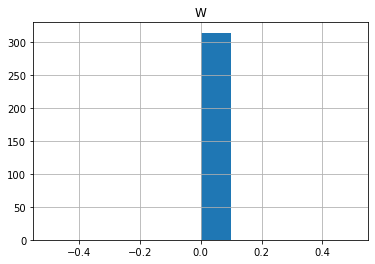

In [525]:
ancom_df.hist(column='W')

In [650]:
L2_df_nona.shape

(33, 16)

### Generate PCoA biplot 
This needs to be done mostly separately from the core-diversity-results because of the need to collapse the taxa to the level desired to be shown in the plot. 

#### Make a table that is collapse to the taxonomic level that you want depicted in the biplot
For this biplot we collapsed to the phyla level. We used the rarefied table that is an output for the core-diversty command to keep everything consistent with other results that would be reported. 

In [526]:
! qiime taxa collapse \
--i-table core-diversity-results/rarefied_table.qza \
--i-taxonomy taxonomy-silva.qza \
--p-level 2 \
--o-collapsed-table core-diversity-results/phyla-rarefied_table.qza


Saved FeatureTable[Frequency] to: core-diversity-results/phyla-rarefied_table.qza


#### Make a relative frequency table from the rarefied-collapsed table 

In [527]:
! qiime feature-table relative-frequency \
--i-table core-diversity-results/phyla-rarefied_table.qza \
--o-relative-frequency-table core-diversity-results/phyla-rarefied-relative-frequency-table.qza 

Saved FeatureTable[RelativeFrequency] to: core-diversity-results/phyla-rarefied-relative-frequency-table.qza


#### Make PCoA results artifact from the Weighted UniFrac distance matrix produced in the core-diversity analysis
There is already weighted-unifrac-pcoa-results.qza file, but it cannot be used because there is a problem with dimension 41. Therefore it is necessary to make this separately and specify the dimension parameter to 40

In [863]:
! qiime diversity pcoa \
--i-distance-matrix core-diversity-results/bray_curtis_distance_matrix.qza \
--p-number-of-dimensions 40 \
--o-pcoa core-diversity-results/bray_curtis_pcoa_dim40.qza 


Saved PCoAResults to: core-diversity-results/bray_curtis_pcoa_dim40.qza


#### Make a qiime biplot artifact that is a combination of the PCoA results and the relative frequency table

In [864]:
! qiime diversity pcoa-biplot \
--i-pcoa core-diversity-results/bray_curtis_pcoa_dim40.qza \
--i-features core-diversity-results/phyla-rarefied-relative-frequency-table.qza  \
--o-biplot biplot-bray-L2.qza


Saved PCoAResults % Properties('biplot') to: biplot-bray-L2.qza


#### Make the biplot visualization

In [865]:
! qiime emperor biplot \
--i-biplot biplot-bray-L2.qza \
--m-sample-metadata-file Categorical-meta-v3.tsv \
--o-visualization biplot-bray-L2.qzv

Saved Visualization to: biplot-bray-L2.qzv


In [866]:
viz = Visualization.load('biplot-bray-L2.qzv')
viz

<visualization: Visualization uuid: 7bf95fa4-c44d-43d5-8bea-13994e62dcb6>

## Taxa barplot

In [653]:
table_noNA = Artifact.load('noMito_noChloro-filtered-table.qza')

#turn it into a dataframe and then remove from the feature table all the time 3
table_noNA = table_noNA.view(pd.DataFrame)
table_noNA = table_noNA[metadata_API_df['Chemotherapy-cat'].isna()==False]

#turn back into an api artifact
table_noNA = Artifact.import_data("FeatureTable[Frequency]", table_noNA)

#export its data to be usable by the CLI
table_noNA.export_data('table_noNA')

/opt/anaconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [654]:
#turn it into a CLI-usable artifact
! qiime tools import \
--type FeatureTable[Frequency] \
--input-path table_noNA/feature-table.biom \
--output-path table_noNA.qza

Imported table_noNA/feature-table.biom as BIOMV210DirFmt to table_noNA.qza


In [655]:
! qiime taxa barplot \
--i-table table_noNA.qza \
--i-taxonomy taxonomy-silva.qza \
--m-metadata-file Categorical-meta-noNA.tsv \
--o-visualization taxa-barplot-noNA.qzv


Saved Visualization to: taxa-barplot-noNA.qzv


In [656]:
viz = Visualization.load('taxa-barplot-noNA.qzv')
viz

<visualization: Visualization uuid: 563dbd37-f34e-4b87-a5e9-43f707a1c4d5>

## Alpha Diversity Boxplots

In [868]:
faiths_vector = Artifact.load('core-diversity-results/faith_pd_vector.qza')

In [886]:
alpha_bc = pd.concat([faiths_vector.view(pd.Series),metadata_API_df[['hcvsbc-cat',
                                                                     'cesd_total_categorical',
                                                                     'fact_c_r_imp_total_categorical']]],
                      axis=1)

/opt/anaconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


(0.0, 100.0)

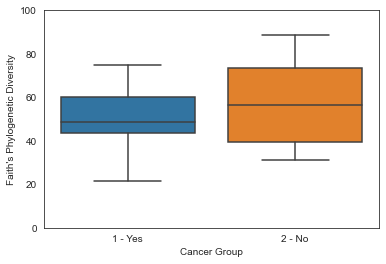

In [887]:
ax = sns.boxplot(x='hcvsbc-cat',y='faith_pd',data=alpha_bc)
ax.set_ylabel('Faith\'s Phylogenetic Diversity')
ax.set_xlabel('Cancer Group')
ax.set_ylim(0,100)

Text(0.5, 0, 'Cancer Group')

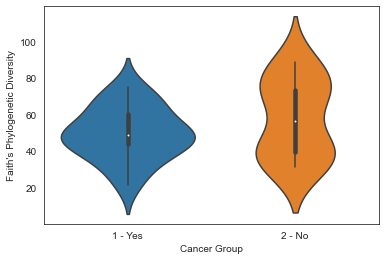

In [884]:
ax = sns.violinplot(x='hcvsbc-cat',y='faith_pd',data=alpha_bc)
ax.set_ylabel('Faith\'s Phylogenetic Diversity')
ax.set_xlabel('Cancer Group')
#ax.set_ylim(0,100)

Interesting bimodal distribution with the No group!

Text(0.5, 0, 'Cancer Group')

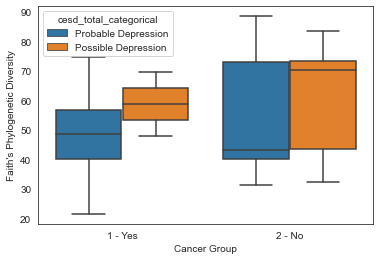

In [885]:
ax = sns.boxplot(x='hcvsbc-cat',y='faith_pd',data=alpha_bc,
                hue='cesd_total_categorical')
ax.set_ylabel('Faith\'s Phylogenetic Diversity')
ax.set_xlabel('Cancer Group')
#ax.set_ylim(0,100)

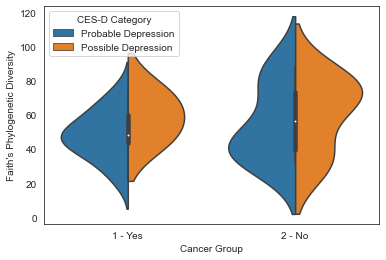

In [898]:
ax = sns.violinplot(x='hcvsbc-cat',y='faith_pd',data=alpha_bc,
                    hue='cesd_total_categorical',
                    split=True)
ax.set_ylabel('Faith\'s Phylogenetic Diversity')
ax.set_xlabel('Cancer Group')
ax.legend(title='CES-D Category',loc=2)
#ax.set_ylim(0,100)

Text(0.5, 0, 'Cancer Group')

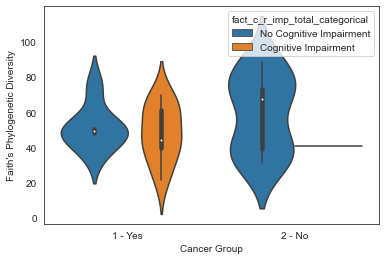

In [888]:
ax = sns.violinplot(x='hcvsbc-cat',y='faith_pd',data=alpha_bc,
                   hue='fact_c_r_imp_total_categorical')
ax.set_ylabel('Faith\'s Phylogenetic Diversity')
ax.set_xlabel('Cancer Group')
#ax.set_ylim(0,100)

In [903]:
OTUs_vector = Artifact.load('core-diversity-results/observed_features_vector.qza').view(pd.Series)
Pielous_vector = Artifact.load('core-diversity-results/evenness_vector.qza').view(pd.Series)
Shannon_vector = Artifact.load('core-diversity-results/shannon_vector.qza').view(pd.Series)

In [904]:
alpha_bc = pd.concat([alpha_bc,
                      OTUs_vector,
                      Pielous_vector,
                      Shannon_vector],
                     axis=1)

/opt/anaconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [905]:
alpha_bc.head()

faith_pd hcvsbc-cat  ... pielou_evenness shannon_entropy
1         NaN    1 - Yes  ...             NaN             NaN
10  67.279588     2 - No  ...        0.924223        7.605265
11  73.799269        NaN  ...        0.936638        7.773357
12  40.645350     2 - No  ...        0.873221        6.549025
13  33.697789        NaN  ...        0.808192        6.008609

[5 rows x 7 columns]

Text(0.5, 0, 'Cancer Group')

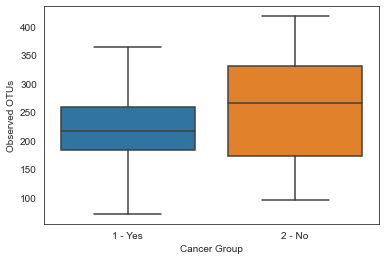

In [927]:
ax = sns.boxplot(x='hcvsbc-cat',y='observed_features',data=alpha_bc)
ax.set_ylabel('Observed OTUs')
ax.set_xlabel('Cancer Group')
#ax.legend(title='CES-D Category',loc=2)

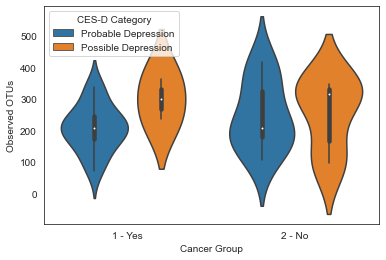

In [926]:
ax = sns.violinplot(x='hcvsbc-cat',y='observed_features',data=alpha_bc,
              hue='cesd_total_categorical')
ax.set_ylabel('Observed OTUs')
ax.set_xlabel('Cancer Group')
ax.legend(title='CES-D Category',loc=2)

In [917]:
melted_df = pd.melt(alpha_bc.drop(['cesd_total_categorical','fact_c_r_imp_total_categorical'],axis=1),
                    id_vars='hcvsbc-cat')

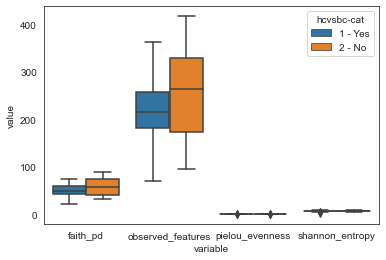

In [933]:
sns.boxplot(x='variable',y='value',data=melted_df,hue='hcvsbc-cat')


Text(0.5, 0, 'Cancer Group')

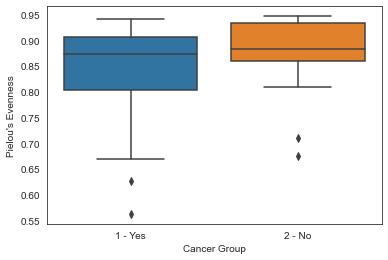

In [936]:
ax = sns.boxplot(x='hcvsbc-cat',y='pielou_evenness',data=alpha_bc)
ax.set_ylabel('Pielou\'s Evenness')
ax.set_xlabel('Cancer Group')
#ax.legend(title='CES-D Category',loc=2)

Text(0.5, 0, 'Cancer Group')

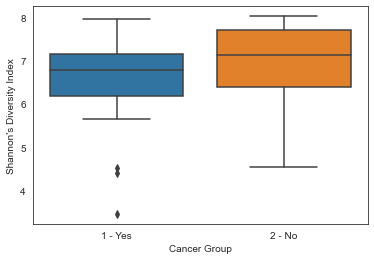

In [938]:
ax = sns.boxplot(x='hcvsbc-cat',y='shannon_entropy',data=alpha_bc)
ax.set_ylabel('Shannon\'s Diversity Index')
ax.set_xlabel('Cancer Group')
#ax.legend(title='CES-D Category',loc=2)

Text(0.5, 0, 'Cancer Group')

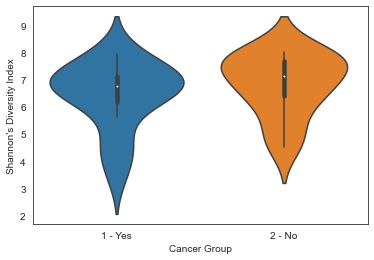

In [941]:
ax = sns.violinplot(x='hcvsbc-cat',y='shannon_entropy',data=alpha_bc)
ax.set_ylabel('Shannon\'s Diversity Index')
ax.set_xlabel('Cancer Group')
#ax.legend(title='CES-D Category',loc=2)

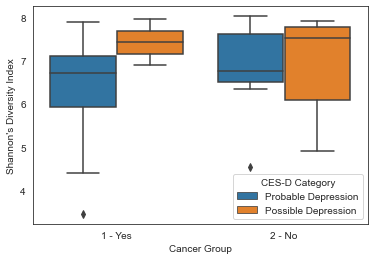

In [942]:
ax = sns.boxplot(x='hcvsbc-cat',y='shannon_entropy',data=alpha_bc,
                hue='cesd_total_categorical')
ax.set_ylabel('Shannon\'s Diversity Index')
ax.set_xlabel('Cancer Group')
ax.legend(title='CES-D Category')

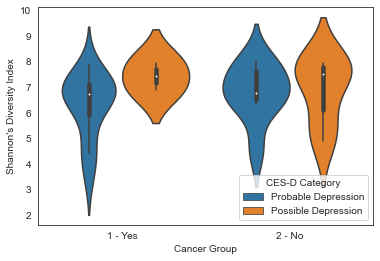

In [949]:
ax = sns.violinplot(x='hcvsbc-cat',y='shannon_entropy',data=alpha_bc,
                hue='cesd_total_categorical')
ax.set_ylabel('Shannon\'s Diversity Index')
ax.set_xlabel('Cancer Group')
ax.legend(title='CES-D Category',loc=4)

## Linear Discriminate Analysis

Going to try this, we'll see how it goes.

Update: was not very helpful, not a lot of interest in me continuing down this rabbit hole from other group members.

In [538]:
L2_df_nona = L2_table_df.dropna()

In [539]:
L2_df_nona.drop('Chemotherapy-cat',axis=1,inplace=True)

/opt/anaconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [541]:
L2_df_nona.drop('depth',axis=1,inplace=True)

/opt/anaconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [542]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [648]:
X = L2_df_nona.drop('hcvsbc-cat',axis=1)
y = L2_df_nona['hcvsbc-cat']

In [609]:
lda = LinearDiscriminantAnalysis(n_components=1)
lda.fit(X,y)

LinearDiscriminantAnalysis(n_components=1)

In [610]:
data = {L2_df_nona.columns[i]:lda.coef_[0][i] for i in range(len(lda.coef_[0]))}

In [611]:
coef_df = pd.DataFrame.from_dict(data,orient='index')

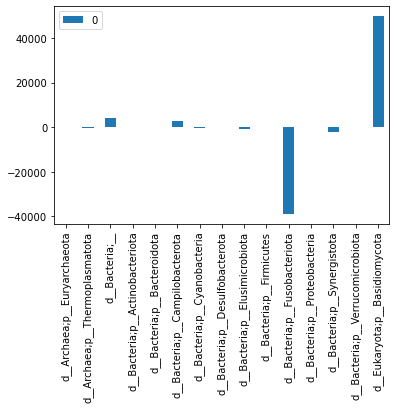

In [612]:
coef_df.plot(kind='bar')

In [613]:
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit(X,y).transform(X)

In [1]:
plt.figure()
plt.scatter(L2_df_nona['hcvsbc-cat'],X_lda)

NameError: name 'plt' is not defined

In [594]:
X_lda[y==0]

array([], shape=(0, 1), dtype=float64)

In [599]:
L2_df_nona.columns

Index(['d__Archaea;p__Euryarchaeota', 'd__Archaea;p__Thermoplasmatota',
       'd__Bacteria;__', 'd__Bacteria;p__Actinobacteriota',
       'd__Bacteria;p__Bacteroidota', 'd__Bacteria;p__Campilobacterota',
       'd__Bacteria;p__Cyanobacteria', 'd__Bacteria;p__Desulfobacterota',
       'd__Bacteria;p__Elusimicrobiota', 'd__Bacteria;p__Firmicutes',
       'd__Bacteria;p__Fusobacteriota', 'd__Bacteria;p__Proteobacteria',
       'd__Bacteria;p__Synergistota', 'd__Bacteria;p__Verrucomicrobiota',
       'd__Eukaryota;p__Basidiomycota', 'hcvsbc-cat'],
      dtype='object')

In [600]:
L2_df_nona[['d__Bacteria;p__Fusobacteriota','hcvsbc-cat','d__Eukaryota;p__Basidiomycota']]

d__Bacteria;p__Fusobacteriota hcvsbc-cat  d__Eukaryota;p__Basidiomycota
1                        0.000000    1 - Yes                       0.000000
10                       0.000000     2 - No                       0.000000
12                       0.000000     2 - No                       0.000000
14                       0.000000    1 - Yes                       0.000000
15                       0.000000     2 - No                       0.000000
17                       0.000000    1 - Yes                       0.000000
19                       0.000000     2 - No                       0.000000
21                       0.000000    1 - Yes                       0.000000
22                       0.000000    1 - Yes                       0.000000
23                       0.000000    1 - Yes                       0.000000
24                       0.000101    1 - Yes                       0.000000
25                       0.000000    1 - Yes                       0.000000
26                       0.003091     2 - No                       0.002531
28                       0.000000    1 - Yes                       0.000000
29                       0.000000    1 - Yes                       0.000000
3                        0.000000     2 - No                       0.000000
30                       0.000000    1 - Yes                       0.000000
31                       0.000000    1 - Yes                       0.000000
32                       0.000000    1 - Yes                       0.000000
33                       0.000000    1 - Yes                       0.000000
34                       0.000000     2 - No                       0.000000
36                       0.000000     2 - No                       0.000000
38                       0.000000    1 - Yes                       0.000000
39                       0.000000     2 - No                       0.000000
4                        0.000000     2 - No                       0.000000
41                       0.000000    1 - Yes                       0.000000
42                       0.000000     2 - No                       0.000000
43                       0.000000     2 - No                       0.000000
44                       0.000000    1 - Yes                       0.000000
45                       0.000000    1 - Yes                       0.000000
46                       0.000000    1 - Yes                       0.000000
6                        0.000000     2 - No                       0.000000
8                        0.000000     2 - No                       0.000000